# M5A 회귀분석을 통한 매출예측 방법
- 회귀분석 기초 개념
- 모델링용 데이터 준비 과정
- 시계열 데이터의 시각화
- 회귀분석 모델 생성
- 매출예측, 외부환경변화영향 분석에 회귀분석 활용
<br><br>
- [목표] 모델링 방법 중 **가장 기본적인 개념**인 회귀분석을 활용해 매출을 예측하는 방법을 이해


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from numpy.polynomial.polynomial import polyfit

# define random jitter
def rjitt(arr):
    stdev = .01*(max(arr)-min(arr))
    return arr + np.random.randn(len(arr)) * stdev

def rjitt5(arr):
    stdev = .07*(max(arr)-min(arr))
    return arr + np.random.randn(len(arr)) * stdev

# custom min max scaler
def mnmx_scl(vec):
    vec = (vec-vec.min())/(vec.max()-vec.min())
    return(vec)

def zrmx_scl(vec):
    vec = vec/vec.max()
    return(vec)

# 값별 인원수와 구성비를 dataframe 형태로 출력하는 함수
def cntnpcnt(x):
    # x is supposed to be a pandas series
    dfx = pd.DataFrame(x)
    dfx['recCnt'] = 1
    dfx = dfx.groupby(dfx.columns[0]).count().reset_index()
    dfx['pcntrecCnt'] = dfx.recCnt/dfx.recCnt.sum() *100
    return(dfx)


import warnings
warnings.filterwarnings('ignore')


# local data path
dataPath = 'D:/YONG/myPydata/' # 위치는 사용자 지정


import matplotlib.font_manager
    
# matplotlib 에서 한글을 표시하기 위한 설정
font_name = matplotlib.font_manager.FontProperties(
                fname="c:/Windows/Fonts/malgun.ttf"  # 윈도우즈의 한글 폰트 위치를 지정
            ).get_name()
matplotlib.rc('font', family=font_name)
matplotlib.rcParams['axes.unicode_minus'] = False #  음수를 나타내는 '-' 부호가 정상 표시되도록


## 데이터 불러오기

In [2]:
# 상품 테이블 불러오기
itemmast = pd.read_csv(dataPath + 'brk_itemmast01.csv', encoding='euc-kr')
itemmast = itemmast.drop(itemmast.columns[0], axis=1)

# 판매내역 테이블 불러오기
sales = pd.read_csv(dataPath + 'brk_salesmast01.csv', encoding='euc-kr')
sales = sales.drop(sales.columns[0], axis=1)

# 고객 테이블 불러오기
custmast = pd.read_csv(dataPath + 'brk_custmast01.csv', encoding='euc-kr')
custmast = custmast.drop(custmast.columns[0], axis=1)


In [3]:
# 판매내역 테이블 보기

print(sales.shape)
sales[['date','amt']].sample(5)

(41936, 19)


,date,amt
19219,2019-07-07 16:54:05.113268,70000
34644,2020-04-05 14:50:41.068969,80000
39384,2020-07-30 12:04:27.924671,60000
527,2019-10-05 12:23:32.735425,70000
16031,2020-05-15 16:34:32.473315,135000


## Section 1 : 전체매출의 월별 집계 - 탐색적 기초 분석
- 전체 매출의 추이 파악을 통해 매출예측을 위해 어떤 방식을 사용해야할 것인지 검토

In [4]:
# 월별 매출액 집계 ~ 2019~2020 2개년간 월별 집계

sales01 = sales[['date','amt']]
# 월까지의 항목 추출해 별도 컬럼으로
sales01['saleMon'] = sales01.date.str.slice(0,7)
display(sales01.sort_values('saleMon').head())
display(sales01.sort_values('saleMon').tail())

# \n 으로 텍스트 출력 전에 한줄 띄우기
print('\n집계된 월별 매출 확인')

sales02 = sales01[['saleMon', 'amt']].groupby('saleMon').sum().reset_index()
display(sales02.tail())

,date,amt,saleMon
6138,2019-01-02 14:50:36.926853,100000,2019-01
1370,2019-01-21 19:02:13.719480,100000,2019-01
1369,2019-01-21 17:45:18.267615,80000,2019-01
1367,2019-01-21 18:58:16.553163,230000,2019-01
1364,2019-01-21 18:33:22.242769,70000,2019-01


,date,amt,saleMon
28605,2020-12-01 09:09:34.442499,110000,2020-12
28602,2020-12-01 10:59:51.143300,80000,2020-12
28599,2020-12-11 13:38:56.524505,35000,2020-12
28596,2020-12-11 12:54:36.772643,120000,2020-12
18103,2020-12-02 22:36:27.795051,140000,2020-12



집계된 월별 매출 확인


,saleMon,amt
19,2020-08,132261000
20,2020-09,222280000
21,2020-10,117480000
22,2020-11,256118000
23,2020-12,234235000


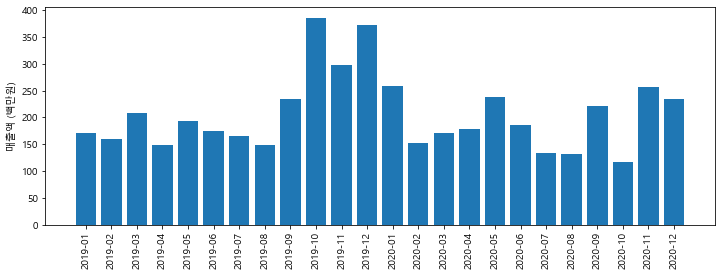

In [5]:
# 전체 매출 월별 추이 시각화 

# 챠트의 가로세로 크기를 지정
# 가로, 세로 순서로 지정
plt.figure(figsize=(12,4)) 

plt.bar(sales02.saleMon, sales02.amt/1e+6)
plt.ylabel('매출액 (백만원)')
plt.xticks(rotation=90)
plt.show()

- 시간의 흐름에 따라 변화가 나타나는 것 처럼 보이지만 세부적으로는 직선의 관계(추세)와 동시에 계절적인 차이 패턴도 존재하는 듯
- 2019 겨울에 매출이 컸으나 2020 겨울에는 전년에 비해 전체적으로 상당히 감소한 패턴

- **[참고]** plt.figure(figsize=(width, height)) 에서 폭과 높이의 default 는 [6.4, 4.8]

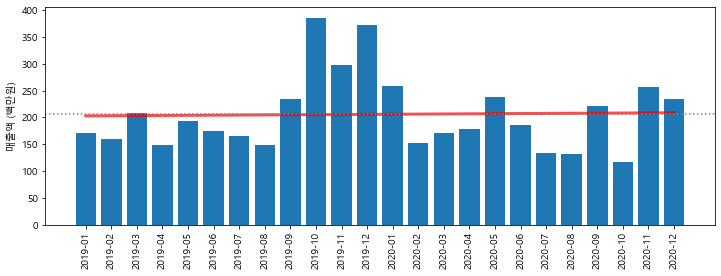

In [6]:
# 전체 매출 월별 추이 시각화 

plt.figure(figsize=(12,4)) # 챠트의 가로세로 크기를 지정
# XY 순서로 지정

plt.bar(sales02.saleMon, sales02.amt/1000000)
plt.ylabel('매출액 (백만원)')
plt.xticks(rotation=90)

# 계절성과 기타의 변동이 있다는 점을 무시하고 전체적인 추세만 본다면?
# 추세 : 각 월의 막대들의 중간을 통과하는 직선
varx = np.arange(len(sales02))
vary = sales02.amt/1e+6
plt.plot(np.unique(varx), np.poly1d(np.polyfit(varx, vary, 1))(np.unique(varx)), 
         color='red', linewidth=3, alpha=0.7)
# 평균선
plt.axhline(vary.mean(), color='grey', linestyle=':')
plt.show()

- **추세선**(red)과 **평균선**(dotted grey)간에 거의 차이 없음
- == 증가도 감소도 없는 추세?
<br><br>
- 매출추이를 분석하는데 필수적인 **계절 영향**을 무시했기에 발생된 결과
- 사용한 **데이터 기간이 짧은 (3년미만)** 영향도 

### 상품군별 매출 추이 비교

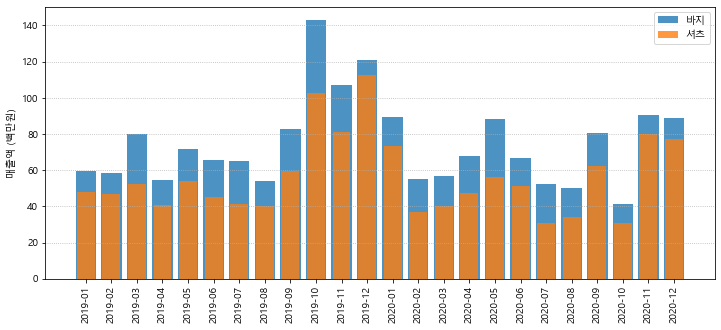

In [7]:
# 바지와 셔츠 두 가지 상품군의 매출 월별 추이 비교 시각화 

# 각각의 매출 집계 계산
sales01a = sales[sales.scat=='바지'][['date','amt']]
sales01a['saleMon'] = sales01a.date.str.slice(0,7)
sales02a = sales01a[['saleMon', 'amt']].groupby('saleMon').sum().reset_index()

sales01b = sales[sales.scat=='셔츠'][['date','amt']]
sales01b['saleMon'] = sales01b.date.str.slice(0,7)
sales02b = sales01b[['saleMon', 'amt']].groupby('saleMon').sum().reset_index()

# 바지와 셔츠 매출 월별 추이 비교 시각화 

plt.figure(figsize=(12,5))
# 바지
plt.bar(sales02a.saleMon, sales02a.amt/1e+6, alpha=0.8)
# 셔츠
plt.bar(sales02b.saleMon, sales02b.amt/1e+6, alpha=0.8, width=0.7)
plt.ylabel('매출액 (백만원)')
plt.legend(['바지','셔츠'])
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle=':') # 가로줄만 보조선 추가
plt.show()

- **분석결과에 대한 검토**: 상품군과 무관하게 유사한 계절성과 추세?

### 실무에서 흔히 사용하는 분석 방식 - 전년동기대비 변화 검토

,saleMon,amt,yr,mon
18,2020-07,30980000,2020,07
23,2020-12,77440000,2020,12
6,2019-07,41290000,2019,07
9,2019-10,102585000,2019,10
12,2020-01,73125000,2020,01


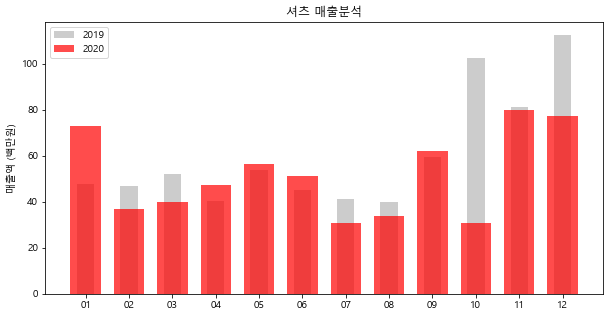

In [8]:
# 위에서 생성한 셔츠 월별 매출 집계를 활용
sales02b1 = sales01b[['saleMon', 'amt']].groupby('saleMon').sum().reset_index()

# 연도를 구별하는 컬럼 추가
sales02b1['yr'] = np.sort(np.repeat([2019,2020], 12))

# 월을 구별하는 컬럼 추가
sales02b1['mon'] = sales02b1.saleMon.str.slice(5,7)
display(sales02b1.sample(5))

# 1차년도 테이블 분리
# reset_index(drop=True) 인덱스를 0부터 새로 부여
tmpShirtSaless1 = sales02b1.head(12).reset_index(drop=True)
# 2차년도 테이블 분리
tmpShirtSaless2 = sales02b1.tail(12).reset_index(drop=True)

plt.figure(figsize=(10,5))
plt.bar(tmpShirtSaless1.mon, tmpShirtSaless1.amt/1e+6, alpha=0.4, width=0.4, color='grey')
plt.bar(tmpShirtSaless2.mon, tmpShirtSaless2.amt/1e+6, alpha=0.7, width=0.7, color='red')
plt.ylabel('매출액 (백만원)')

# 월만 표시하므로 xticks 회전 불필요
# plt.xticks(rotation=90)
plt.title('셔츠 매출분석')
plt.legend([2019,2020])
plt.show()

In [9]:
# 피보팅으로 처음부터 연도별 월의 두 개 컬럼으로 생성

dfsaleShirts = sales02b1.pivot(index='mon', columns='yr', values='amt').reset_index()
dfsaleShirts

yr,mon,2019,2020
0,01,47725000,73125000
1,02,46935000,36751000
2,03,52160000,39980000
3,04,40485000,47175000
4,05,54019000,56482000
5,06,45010000,51355000
6,07,41290000,30980000
7,08,39918000,33990000
8,09,59400000,62045000
9,10,102585000,30960000


In [10]:
# 전년동기대비 증가율 (YoY Year over Year %) 지수 생성

dfsaleShirts['yoy'] = round((dfsaleShirts[2020]-dfsaleShirts[2019])/dfsaleShirts[2019]*100,1)
dfsaleShirts

yr,mon,2019,2020,yoy
0,01,47725000,73125000,53.2
1,02,46935000,36751000,-21.7
2,03,52160000,39980000,-23.4
3,04,40485000,47175000,16.5
4,05,54019000,56482000,4.6
5,06,45010000,51355000,14.1
6,07,41290000,30980000,-25.0
7,08,39918000,33990000,-14.9
8,09,59400000,62045000,4.5
9,10,102585000,30960000,-69.8


In [11]:
# 2019, 2022 연도별 합계 비교

dfsaleShirts[2019].sum(), dfsaleShirts[2020].sum(), dfsaleShirts[2020].sum() / dfsaleShirts[2019].sum()

(723124000, 620023000, 0.8574227933245198)

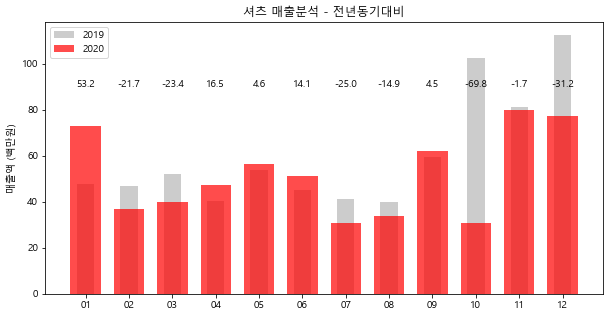

In [12]:
plt.figure(figsize=(10,5))
# 1차년도를 먼저 표시
plt.bar(tmpShirtSaless1.mon, tmpShirtSaless1.amt/1e+6, alpha=0.4, width=0.4, color='grey')
# 2차년도를 표시
plt.bar(tmpShirtSaless2.mon, tmpShirtSaless2.amt/1e+6, alpha=0.7, width=0.7, color='red')
# 2차년도(최근)가 중요하므로 강조 -- red

plt.ylabel('매출액 (백만원)')
plt.title('셔츠 매출분석 - 전년동기대비')
plt.legend([2019,2020])

# 증가 지표 표시
for i in dfsaleShirts.index:
    plt.text(tmpShirtSaless1.mon[i], 90, dfsaleShirts.yoy[i], ha='center')
plt.show()

**[전년동기대비 분석의 함정]**
- 전년이 특수한 상황이었을 경우나 전년 중 일부만 특수한 상황이었을 경우 등에서 비교가 무의미함
- 전년동기대비는 기간이 짧다는 점에서 특히 많은 문제점 내포 - 딱 두개 시점만 가지고 비교
- (무의미한 비교를 통한 결과를 설득하려는 방향으로 분석이 왜곡되는 함정에 빠지지 않도록 주의 필요)

## Section 2 : 회귀분석 

## 회귀분석 기본개념

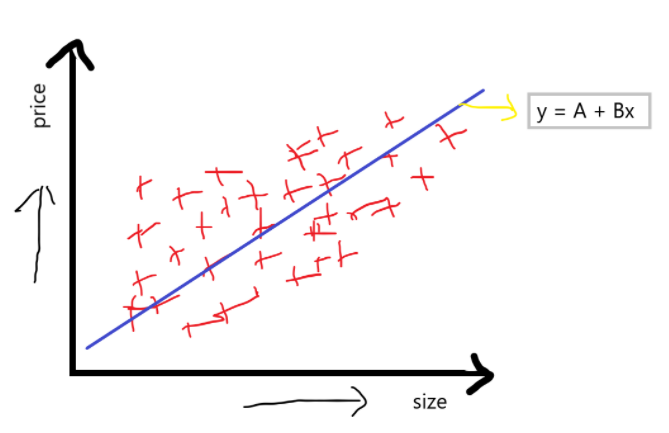

- 한 변수 값의 변화에 따라 다른 변수 값이 어떻게 달라지는 관계가 있는가를 나타내는 모델
- 독립변수(size: X)와 종속변수(price: Y)간의 관계를 선형(linear) 관계로 파악
- X와 Y 모두 숫자 형식이어야함 (numeric 즉, int 또는 float)
<br><br>
- 단순선형회귀분석 (simple linear regression) 에서는 한 개의 X 변수만을 고려

### 간단한 회귀분석 예 - 연령과 소득의 관계

In [13]:
# 고객의 연령과 소득 간의 관계를 분석

# custmast 데이터에서 연령과와 추정소득 두 컬럼만 추출
dfctmpa1 = custmast[['age', 'hh_income']]
print(dfctmpa1.shape)
dfctmpa1.sample(5)

# hh_income은 고객별 가구합산소득에 대한 추정치라고 가정

(26000, 2)


,age,hh_income
5663,32,68000
12369,43,86000
17941,29,60000
17946,25,53000
1466,30,58000


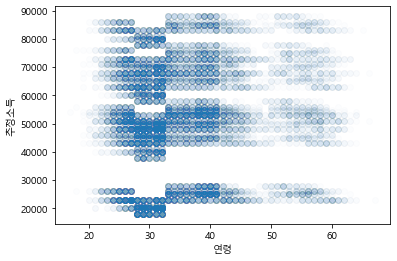

In [14]:
# 산점도를 활용한 분포 확인

plt.scatter(dfctmpa1.age, dfctmpa1.hh_income, alpha=0.01)
plt.xlabel('연령')
plt.ylabel('추정소득')
plt.show()

# 30세 전후에 가구합산소득은 낮은 패턴 -- 결혼이나 취업등으로 가구분리 독립하는 영향?

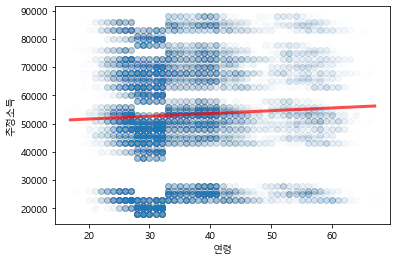

In [15]:
# 산점도에 회귀분석을 통한 회귀선 추가

plt.scatter(dfctmpa1.age, dfctmpa1.hh_income, alpha=0.01)
plt.xlabel('연령')
plt.ylabel('추정소득')

varx = dfctmpa1.age
vary = dfctmpa1.hh_income
# 선형회귀선 추가
plt.plot(np.unique(varx), np.poly1d(np.polyfit(varx, vary, 1))(np.unique(varx)), 
         color='red', linewidth=3, alpha=0.7)
plt.show()

# 선형적인 관계만 보면 연령이 많을수록 가구합산소득이 많은 관계

[해석시 주의 필요 사항] 
- 일반적으로 가구 구성원의 연령이 많아질수록 가구합산 소득이 증가할까? 연령대별로 가구구성원의 수에도 차이가 있지는 않을까? 
- 가구전체 소득의 합산 수치 뿐 아니라 구성원수가 있어야 유용하지는 않을까?
- 분석결과가 일반적인 특성인가 아니면 당사의 특수한 패턴인가?

## 매출추세에 대한 회귀분석

,saleMon,amt
19,2020-08,132261000
20,2020-09,222280000
21,2020-10,117480000
22,2020-11,256118000
23,2020-12,234235000


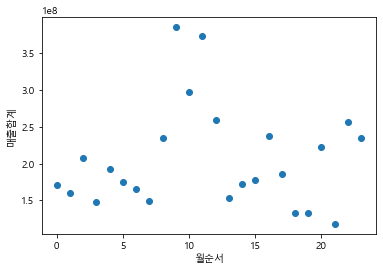

In [16]:
# 시간순서를 X축으로 삼아 회귀분석 ==> 추세를 예측하는데 사용할 수 있는 모델?

# 전체 매출 데이터 sales02
display(sales02.tail())

# 월은 숫자가 아니므로 순서 일련번호를 X로 사용
plt.scatter(np.arange(len(sales02)), sales02.amt)
plt.xlabel('월순서') # X 독립변수 independent variable
plt.ylabel('매출합계') # Y 종속변수 dependent variable
plt.show()

**검토사항**
- 두 변수 월순서와 매출합계 간의 관계는? (선형 관점에서)
- 점들의 중간을 통과하는 하나의 직선?

### 상관계수
- 상관계수(correlation coefficient) -- 두 변수간에 양(같은) 또는 음(반대)의 방향으로 얼마나 강한 선형적인 관계를 가지는지를 하나의 숫자로 나타냄
- 한 변수의 값이 변하면 나머지 변수의 값도 변하는 관계가 얼마나 강한가? (순서무관)

In [17]:
# numpy를 사용해 월의 일련번호와 매출간의 상관계수 구하기 

np.corrcoef(np.arange(len(sales02)), sales02.amt) # 두 개의 변수 X 두 개의 변수 = 매트릭스 (matrix 행렬 table)

array([[1.        , 0.02547664],
       [0.02547664, 1.        ]])

In [18]:
# X와 Y의 관계는 대각선의 1이 아닌 값 하나임
# 매트릭스는 대칭. 결국 한 개 값만 필요

np.corrcoef(np.arange(len(sales02)), sales02.amt)[0,1]

0.025476643394213704

- 상관관계 값이 음수이면 반대방향의 관계
- 즉, 한 쪽이 증가하면 나머지는 감소

In [19]:
# pandas를 사용한 상관계수 구하기

# 월의 일련번호와 매출 두 값들을 리스트로 변환
# 리스트를 데이터프레임으로 변환
# 행렬바꿈을 한 후 corr() 함수를 적용해 매트릭스 생성
# (데이터프레임내의 컬럼들간 관계에 대해 상관계수 구하기에 편리)

pd.DataFrame([np.arange(len(sales02)), sales02.amt]).T.corr()

,0,1
0,1.000000,0.025477
1,0.025477,1.000000


#### 상관관계 correlation 의 의미 살펴보기 

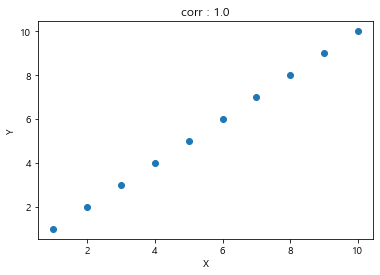

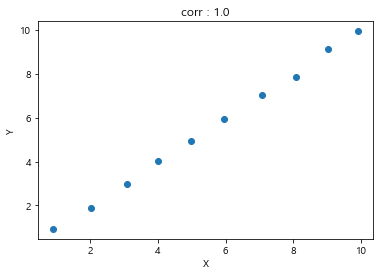

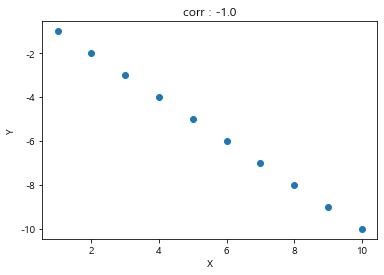

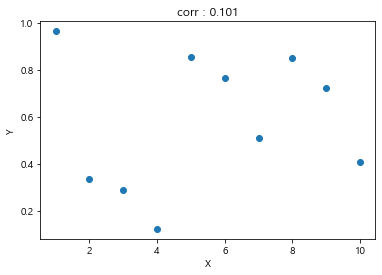

In [20]:
a = [1,2,3,4, 5, 6, 7, 8, 9, 10]

# 완전히 같은 값, 같은 방향인 경우
plt.scatter(a,a)
plt.xlabel('X')
plt.ylabel('Y')
titleText = 'corr : ' + str(round(np.corrcoef(a,a)[0,1],3))
plt.title(titleText)
plt.show()


# 거의 같은 방향인 경우
plt.scatter(rjitt(a),rjitt(a))
plt.xlabel('X')
plt.ylabel('Y')
titleText = 'corr : ' + str(round(np.corrcoef(rjitt(a),rjitt(a))[0,1],3))
plt.title(titleText)
plt.show()


# 완전히 반대 방향인 경우
plt.scatter(a,-np.array(a))
plt.xlabel('X')
plt.ylabel('Y')
titleText = 'corr : ' + str(round(np.corrcoef(a,-np.array(a))[0,1],3))
plt.title(titleText)
plt.show()


# 완전히 무관한 방향인 경우
randomNums = np.random.rand(len(a))
plt.scatter(a,randomNums)
plt.xlabel('X')
plt.ylabel('Y')
titleText = 'corr : ' + str(round(np.corrcoef(a,randomNums)[0,1],3))
plt.title(titleText)
plt.show()


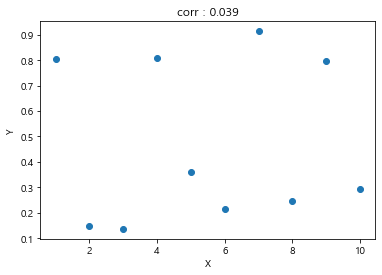

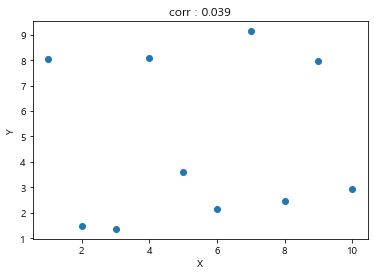

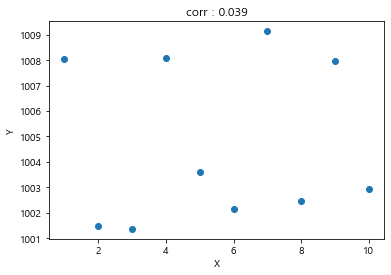

기억할 사항 :
상관계수 크기는 기울기나 절편과는 무관!


In [21]:
# 스케일만 달라진다면 상관계수가 변할까?

# 완전히 무관한 방향인 경우
randomNums = np.random.rand(len(a))
plt.scatter(a,randomNums)
plt.xlabel('X')
plt.ylabel('Y')
titleText = 'corr : ' + str(round(np.corrcoef(a,randomNums)[0,1],3))
plt.title(titleText)
plt.show()

# 스케일만 달라진 경우 
randomNums = randomNums*10

plt.scatter(a,randomNums)
plt.xlabel('X')
plt.ylabel('Y')
titleText = 'corr : ' + str(round(np.corrcoef(a,randomNums)[0,1],3))
plt.title(titleText)
plt.show()


# 절편이 달라진 경우 
randomNums = randomNums + 1000

plt.scatter(a,randomNums)
plt.xlabel('X')
plt.ylabel('Y')
titleText = 'corr : ' + str(round(np.corrcoef(a,randomNums)[0,1],3))
plt.title(titleText)
plt.show()

print('기억할 사항 :\n상관계수 크기는 기울기나 절편과는 무관!')

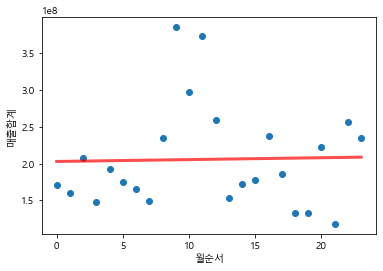

In [22]:
# 월순서와 매출합계간의 선형회귀선 (linear regression line) 추가

plt.scatter(np.arange(len(sales02)), sales02.amt)
plt.xlabel('월순서')
plt.ylabel('매출합계')

varx = np.arange(len(sales02))
vary = sales02.amt
# 선형회귀선
plt.plot(np.unique(varx), np.poly1d(np.polyfit(varx, vary, 1))(np.unique(varx)), 
         color='red', linewidth=3, alpha=0.7)
plt.show()

- red 선형회귀선은 다음달로 한달이 증가할수록 매출합계가 얼마만큼씩 증가하는가를 나타내는 직선
- **선형회귀선 == '추세' (trend)**

In [23]:
# np.poly1d(선형회귀식)(대입할X값리스트)

# 회귀분석을 통해 계산한 추정 Y값은?
print(np.poly1d(np.polyfit(varx, vary, 1))(np.unique(varx)))

print('\n\n')

# 다음 3개월의 Y값은?? -- 회귀분석을 통한 예측 -- 예측 대상은 24~26번째 월이므로
print(np.poly1d(np.polyfit(varx, vary, 1))(np.array([24,25,26])))

[2.02974657e+08 2.03227864e+08 2.03481071e+08 2.03734279e+08
 2.03987486e+08 2.04240694e+08 2.04493901e+08 2.04747108e+08
 2.05000316e+08 2.05253523e+08 2.05506731e+08 2.05759938e+08
 2.06013145e+08 2.06266353e+08 2.06519560e+08 2.06772768e+08
 2.07025975e+08 2.07279182e+08 2.07532390e+08 2.07785597e+08
 2.08038804e+08 2.08292012e+08 2.08545219e+08 2.08798427e+08]



[2.09051634e+08 2.09304841e+08 2.09558049e+08]


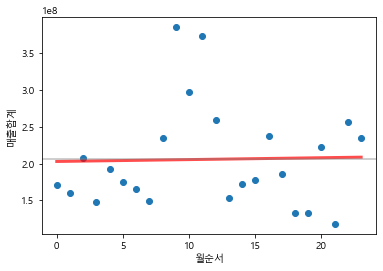

In [24]:
# 월순서와 매출합계간의 선형회귀선 (linear regression line) 

plt.scatter(np.arange(len(sales02)), sales02.amt)
plt.xlabel('월순서')
plt.ylabel('매출합계')
varx = np.arange(len(sales02))
vary = sales02.amt
plt.plot(np.unique(varx), np.poly1d(np.polyfit(varx, vary, 1))(np.unique(varx)), 
         color='red', linewidth=3, alpha=0.7)

# 각 시점의 값에 대한 평균값 선 추가 - 회귀선과 비교용
plt.axhline(np.mean(vary), color='grey', alpha=0.5)
plt.show()

- 차이가 크지는 않지만 평균선과 추세선(회귀)이 정확히 일치하지는 않음
- 단순히 2개년간의 월별 매출액의 시간에 따른 추이를 보면 증가하는 방향처럼 보임
- 실제로는 계절(연말에 매출이 많음)의 차이에 따른 영향이 함께 반영된 결과
- (즉, 연초에서 시작해 연말로 데이터가 끝나기 때문)

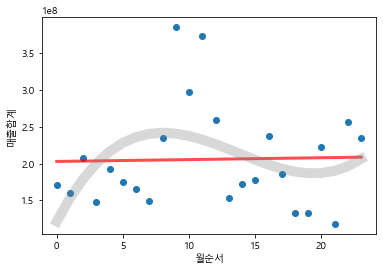

In [25]:
# 월순서와 매출합계간의 선형, polynomial 회귀선 추가

plt.scatter(np.arange(len(sales02)), sales02.amt)
plt.xlabel('월순서')
plt.ylabel('매출합계')
varx = np.arange(len(sales02))
vary = sales02.amt
# 차수==1 (선형)
plt.plot(np.unique(varx), np.poly1d(np.polyfit(varx, vary, 1))(np.unique(varx)), 
         color='red', linewidth=3, alpha=0.7)
# 차수==3 
plt.plot(np.unique(varx), np.poly1d(np.polyfit(varx, vary, 3))(np.unique(varx)), 
         color='grey', linewidth=10, alpha=0.3)
plt.show()

- polynomial 다항식의 차수가 높을 수록 실제 월순서(X)와 매출합계(Y)간의 영역별 관계 변화를 세부적으로 표시
- 변곡점이 여러개로 나타남

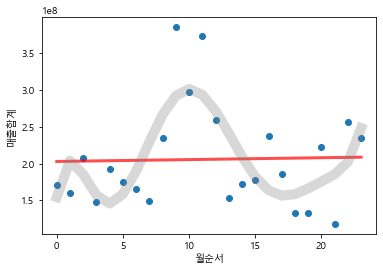

In [26]:
# 월순서와 매출합계간의 선형, polynomial 회귀선 추가

plt.scatter(np.arange(len(sales02)), sales02.amt)
plt.xlabel('월순서')
plt.ylabel('매출합계')
varx = np.arange(len(sales02))
vary = sales02.amt
# 차수==1 (선형)
plt.plot(np.unique(varx), np.poly1d(np.polyfit(varx, vary, 1))(np.unique(varx)), 
         color='red', linewidth=3, alpha=0.7)
# 차수==7 
plt.plot(np.unique(varx), np.poly1d(np.polyfit(varx, vary, 7))(np.unique(varx)), 
         color='grey', linewidth=10, alpha=0.3)
plt.show()

### Scaling 척도 변경

#### Scaling 척도 변경을 위한 사용자 정의 함수 활용

- 사용자정의함수 (user defined function UDF)는 작성자가 원하는 처리를 함수형식으로 작성해서 다른 함수들 처럼 반복해 사용
- 함수는 인수(parameter)와 반환값(return value)을 가질 수 있음

In [27]:
# 간단한 사용자 정의함수의 예 1

def sqrVal(val):
    # 입력받은 값의 제곱을 계산
    val = val**2
    return(val)

sqrVal(5)

25

In [28]:
# 간단한 사용자 정의함수의 예 2

def absDiffs(vec1, vec2):
    # 입력받은 벡터들 간의 차이의 절대값들을 계산
    vec = abs(np.array(vec1) - np.array(vec2))
    return(vec)


absDiffs([3,6,7],[2,4,12]), absDiffs([1,1,1],[2,-4,12])

(array([1, 2, 5]), array([ 1,  5, 11]))

In [29]:
# 사용자정의함수의 활용 예

# custom min max scaler
def mnmx_scl(vec):
    # 최대값과 최소값의 차이로 각 값과 최소값의 차이를 나눠
    # 상대적인 크기를 나타내도록 변경
    vec = (vec-vec.min())/(vec.max()-vec.min())
    return(vec)

def zrmx_scl(vec):
    vec = vec/vec.max()
    return(vec)


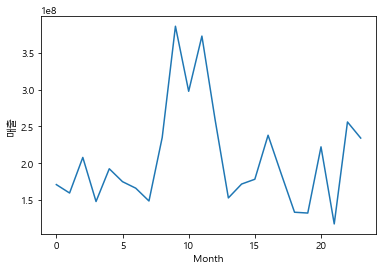

In [30]:
# 척도변환 사용자정의함수 활용 예

# 먼저 원본 값을 사용한 챠트 작성

plt.plot(sales02.amt)
plt.xlabel('Month')
plt.ylabel('매출')
plt.show()

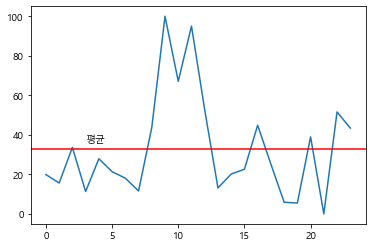

In [31]:
# 척도를 0~100 구간으로 변경 -- 사용자정의함수 활용
scaled_amt = mnmx_scl(sales02.amt) * 100

plt.plot(scaled_amt)
plt.axhline(scaled_amt.mean(), color='red')
# 평균값 보다 약간 위쪽에 선의 의미를 텍스트로 표시
plt.text(3, scaled_amt.mean()*1.1, '평균')
plt.show()

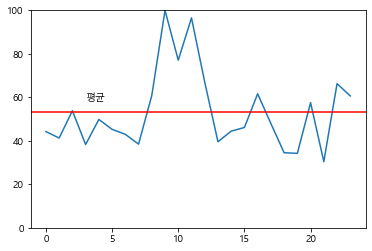

In [32]:
# 척도를 최대100 구간으로 변경 -- 사용자정의함수 활용
scaled_amt = zrmx_scl(sales02.amt) * 100

plt.plot(scaled_amt)
plt.ylim(0,100)
plt.axhline(scaled_amt.mean(), color='red')
# 평균값 보다 약간 위쪽에 선의 의미를 텍스트로 표시
plt.text(3, scaled_amt.mean()*1.1, '평균')
plt.show()

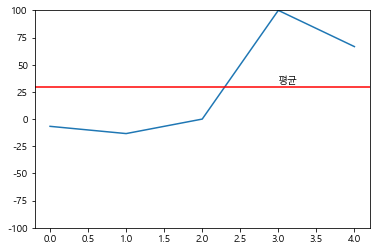

In [33]:
# 함수가 가진 가정의 의미를 확인하는 예제

# 음수값을 포함한 array
amts1 = np.array([-1,-2,0,15,10])
scaled_amt1 = zrmx_scl(amts1) * 100

plt.plot(scaled_amt1)
plt.ylim(-100,100)
plt.axhline(scaled_amt1.mean(), color='red')
plt.text(3, scaled_amt1.mean()*1.1, '평균')
plt.show()

# zrmx_scl은 모든 값이 양수인 경우에 유용
# 음수인 값이 존재하면 최대값의 의미 퇴색됨

In [34]:
# 값별 건수와 구성비를 dataframe 형태로 출력하는 함수

def cntnpcnt(x):
    # x is supposed to be a pandas series
    dfx = pd.DataFrame(x)
    dfx['recCnt'] = 1
    dfx = dfx.groupby(dfx.columns[0]).count().reset_index()
    dfx['pcntrecCnt'] = dfx.recCnt/dfx.recCnt.sum() *100
    return(dfx)

In [35]:
# 판매데이터 중 category 형식 변수 확인

sales[['lcat','scat','store']].tail()

,lcat,scat,store
41931,여성캐주얼,바지,Shoote gasan
41932,여성캐주얼,셔츠,Shoote gasan
41933,여성캐주얼,바지,Esteeme joongang
41934,남성캐주얼,바지,Shoote gasan
41935,여성캐주얼,바지,Multi bupyong


In [36]:
# 사용자정의함수를 활용해서 간편하게 분포 집계

cntnpcnt(sales.store)

,store,recCnt,pcntrecCnt
0,Esteeme joongang,2157,5.143552
1,Multi bupyong,11441,27.282049
2,ONL,12310,29.354254
3,Shoote city,5603,13.360836
4,Shoote gasan,10425,24.859309


<AxesSubplot:>

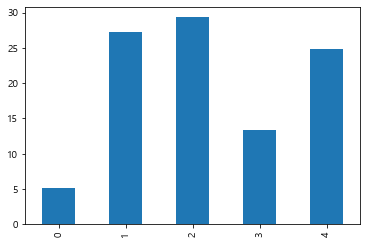

In [37]:
# 집계결과를 바로 시각화

cntnpcnt(sales.store).pcntrecCnt.plot(kind='bar')

## Section 3 : 다중회귀분석 적용
- 다중회귀분석 multiple regression analysis는 X 변수가 여러개인 경우
- 다수의 독립변수 X = {X1,X2,...Xn}를 사용해서 종속변수 Y를 추측하는 모델링

In [38]:
# 전체매출 월별집계 데이터 복제해 사용
# 복제 copy() 후 사용하면 원본값이 바뀌는 일은 없음
sales03 = sales02.copy()

# 시간(월) 순서를 일련번호로
sales03['seq'] = np.arange(len(sales02))

# 연도 무관한 월의 순서를 일련번호로 - 연도가 다르면 다시 시작
sales03['monSeq'] = np.append(np.arange(12), np.arange(12))

# 연도의 순서를 일련 번호로
sales03['yrSeq'] = np.repeat([0,1],12)
sales03

,saleMon,amt,seq,monSeq,yrSeq
0,2019-01,170950000,0,0,0
1,2019-02,159507000,1,1,0
2,2019-03,207905000,2,2,0
3,2019-04,147945000,3,3,0
4,2019-05,192484000,4,4,0
5,2019-06,174938000,5,5,0
6,2019-07,166080000,6,6,0
7,2019-08,148649000,7,7,0
8,2019-09,235010000,8,8,0
9,2019-10,386300000,9,9,0


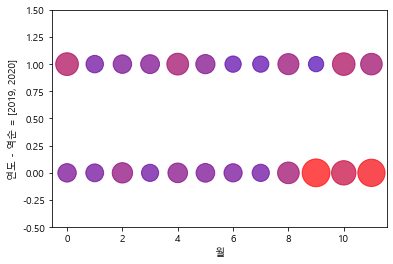

In [39]:
# 월별 매출이 전년과 비슷한 형태인지 확인하는 다른 시각화 방법

# 금액이 크면 붉은색, 작으면 보라색(짙은) 방향으로 표시하도록
colors1 = [[v,0,1-v] for v in sales03.amt/sales03.amt.max()]

# 점의 크기로도 금액 크기를 나타냄 (색상과 크기 보완적 활용)
plt.scatter(sales03.monSeq, sales03.yrSeq, 
            s=sales03.amt/5e+5, # 점크기 지정
            alpha=0.7,
            color=colors1)
plt.xlabel('월')
plt.ylabel('연도 - 역순 = [2019, 2020]')
plt.ylim(-0.5,1.5)
plt.show()

- X축의 월과 Y축의 연도 두 변수 모두가 회귀분석의 X 독립변수
- 즉, X1, X2 의 의미
- 색상과 크기는 Y (매출)

In [40]:
# scikit-learn 라이브러리의 선형회귀분석 모듈을 활용
from sklearn.linear_model import LinearRegression

# 다중선형회귀분석이므로 변수의 리스트를 활용
X = sales03[['monSeq','yrSeq']] # seq는 두 변수로 100% 설명되므로 제외 (중복정보)
y = sales03.amt

# fit() 은 데이터에서 모델을 추출하는 작업
reg = LinearRegression().fit(X, y)

reg.score(X, y)   # 결정계수 R2

# adjusted R-squared
# print(1 - (1-reg.score(X, y))*(len(y)-1)/(len(y)-X.shape[1]-1))


0.2561728211906531

- reg.score() 결과로 산출되는 결정계수 (coefficient of determination) 는 전체 데이터에서의 변동(variation) 중 얼마나 많은 부분을 모델이 설명하는가의 비율
- 0.256 이라는 값을 얻었다면 전체 변동 (X의 차이에 따른 y의 변화) 중에 1/4 정도만 모델이 설명한다는 의미
- 3/4는 모델이 포함한 요소로(즉, X 변수들) 설명할 수 없으니 모델이 예측하는 결과 그대로 될 가능성이 그리 크지는 않다 (**== 설명할 수 없는 변동이 크다 == 추가적인 외부 요소를 충분히 검토해보라**)

In [41]:
# 변수별 계수와 intercept
print(reg.coef_ , reg.intercept_)
print(['월순서의 계수', '연도순서의 계수'],'intercept')

[  8985407.34265734 -31647750.00000002] 172290676.28205127
['월순서의 계수', '연도순서의 계수'] intercept


- 계수의 의미 : 연초에 비해 연말로 갈수록 매출이 크다. (두 개 연도 밖에 없지만) 나중 연도의 매출이 작다
- 이 모델을 사용한 다음 해 매출 예측의 예상 결과: 그 다음 해는 매출이 더 줄어들 것이지만 그 안에서는 연말 쪽이 높은 패턴

#### 모델을 사용한 예측

In [42]:
# 다음 3개월에 대한 값을 모델을 사용해서 예측한다면?

data2predict = np.array([[0,3],[1,3],[2,3]])
# 3차년도의 1~3월
display(pd.DataFrame(data2predict))

# 예측결과 생성
reg.predict(data2predict)


,0,1
0,0,3
1,1,3
2,2,3


array([77347426.2820512 , 86332833.62470855, 95318240.96736589])

In [43]:
# 예측값 계산을 위한 미래 데이터 생성

dfPreds = pd.DataFrame(np.array([[24,0,3],[25,1,3],[26,2,3]]))
dfPreds.columns = ['seq','monSeq','yrSeq']
display(dfPreds)

dfPreds.insert(0,'saleMon',['2021-01','2021-02','2021-03']) # 미래 월 추가
dfPreds.insert(1,'amt',reg.predict(np.array([[0,3],[1,3],[2,3]]))) # 미래 예측 매출액 추가

dfPreds

,seq,monSeq,yrSeq
0,24,0,3
1,25,1,3
2,26,2,3


,saleMon,amt,seq,monSeq,yrSeq
0,2021-01,7.734743e+07,24,0,3
1,2021-02,8.633283e+07,25,1,3
2,2021-03,9.531824e+07,26,2,3


In [44]:
# 두 테이블 결합
# (=과거의 이미 알고있는 실제값 테이블 + 모델에 의해 예측된 값 테이블)
sales02p = pd.concat([sales03,dfPreds])

# 두 테이블을 결합했기에 새로운 테이블에는 시간 순서대로 새로운 index 부여
sales02p.index = np.arange(len(sales02p))

# reset_index() 를 사용해서도 index 다시 부여 가능
# sales02p.reset_index(drop=True, inplace=True)

sales02p.tail()

,saleMon,amt,seq,monSeq,yrSeq
22,2020-11,2.561180e+08,22,10,1
23,2020-12,2.342350e+08,23,11,1
24,2021-01,7.734743e+07,24,0,3
25,2021-02,8.633283e+07,25,1,3
26,2021-03,9.531824e+07,26,2,3


In [45]:
sales02p['pred'] = reg.predict(np.array(sales02p[['monSeq','yrSeq']]))
sales02p.tail()

,saleMon,amt,seq,monSeq,yrSeq,pred
22,2020-11,2.561180e+08,22,10,1,2.304970e+08
23,2020-12,2.342350e+08,23,11,1,2.394824e+08
24,2021-01,7.734743e+07,24,0,3,7.734743e+07
25,2021-02,8.633283e+07,25,1,3,8.633283e+07
26,2021-03,9.531824e+07,26,2,3,9.531824e+07


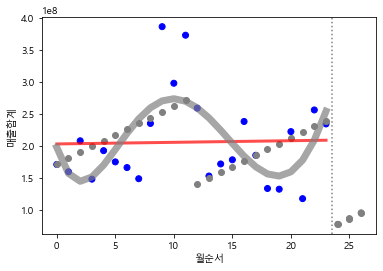

In [46]:
# 다중회귀분석을 통한 매출예측 결과 종합
# 월순서와 매출합계간의 선형, polynomial 회귀선 추가

colors1 = np.where(sales02p.seq<24,'blue','grey')
plt.scatter(np.arange(len(sales02p)), sales02p.amt, color=colors1)
plt.xlabel('월순서')
plt.ylabel('매출합계')

varx = np.arange(len(sales02))
vary = sales02.amt
plt.plot(np.unique(varx), np.poly1d(np.polyfit(varx, vary, 1))(np.unique(varx)), 
         color='red', linewidth=3, alpha=0.7)
plt.plot(np.unique(varx), np.poly1d(np.polyfit(varx, vary, 5))(np.unique(varx)), 
         color='grey', linewidth=7, alpha=0.7)

plt.axvline(23.5, color='grey', linestyle=':')

plt.scatter(np.arange(len(sales02p)), sales02p['pred'], color='grey')
plt.show()

#### 계절성 지수 추가

,mon,meanMonAmt
0,01,0.708012
1,02,0.514467
2,03,0.625223
3,04,0.537198
4,05,0.709156
5,06,0.593243
6,07,0.493189
7,08,0.462669
8,09,0.753173
9,10,0.829744


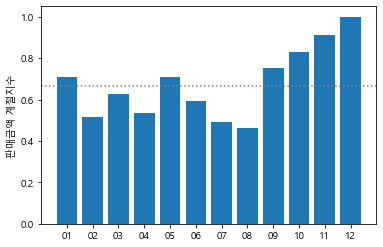

In [47]:
# 월의 순서만으로는 매출의 계절성을 표현하기 어려우므로
# 계절성을 명시적으로 보여주는 변수를 추가
# adding a derived feature

sales04 = sales03.copy()
sales04['mon'] = sales04.saleMon.str.slice(5,7)
# 연도와 무관한 월별 평균 산출
sales04m = sales04[['mon','amt']].groupby('mon').mean().reset_index()
sales04m.columns = ['mon', 'meanMonAmt']

# 계절의 매출지수를 변수로 추가 (최대값을 1로 scaling)
sales04m['meanMonAmt'] = zrmx_scl(sales04m['meanMonAmt'])

# 평균으로 나눈 지수도 사용 가능
# sales04m['meanMonAmt'] = sales04m['meanMonAmt']/sales04m['meanMonAmt'].mean()*100

display(sales04m)

plt.bar(sales04m.mon, sales04m.meanMonAmt)
plt.ylabel('판매금액 계절지수')
plt.axhline(sales04m.meanMonAmt.median(), color='grey', linestyle=':')
plt.show()

In [48]:
# 계절지수 결합

# 월별로 지수를 구한 것이므로 월을 기준으로 merge
sales05 = sales04.merge(sales04m, how='left', on='mon')
sales05

,saleMon,amt,seq,monSeq,yrSeq,mon,meanMonAmt
0,2019-01,170950000,0,0,0,01,0.708012
1,2019-02,159507000,1,1,0,02,0.514467
2,2019-03,207905000,2,2,0,03,0.625223
3,2019-04,147945000,3,3,0,04,0.537198
4,2019-05,192484000,4,4,0,05,0.709156
5,2019-06,174938000,5,5,0,06,0.593243
6,2019-07,166080000,6,6,0,07,0.493189
7,2019-08,148649000,7,7,0,08,0.462669
8,2019-09,235010000,8,8,0,09,0.753173
9,2019-10,386300000,9,9,0,10,0.829744


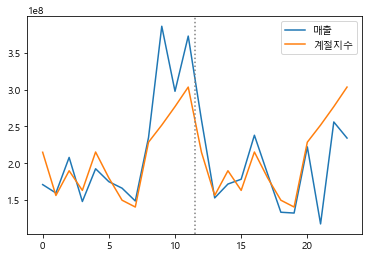

In [49]:
# 매출과 계절지수간 관계 확인

plt.plot(sales05.amt)
# 비교를 편하게 하기 위해 매출과 유사한 스케일로 계절지수를 변환
plt.plot(sales05.meanMonAmt / sales05.meanMonAmt.mean() * sales05.amt.mean())
plt.legend(['매출', '계절지수'])
plt.axvline(11.5, color='grey', linestyle=':')
plt.show()

In [50]:
from sklearn.linear_model import LinearRegression

# 판매금액계절지수 추가 변수를 포함해서 모델 생성
# [월순서, 연도순서, 계절(금액)지수]
X = sales05[['monSeq', 'yrSeq', 'meanMonAmt']]
y = sales05.amt
reg = LinearRegression().fit(X, y)

reg.score(X, y) # 결정계수 R2

# adjusted R-squared
# print(1 - (1-reg.score(X, y))*(len(y)-1)/(len(y)-X.shape[1]-1))

0.5822278094429983

- 월별 매출 평균을 추가 적용한 결과 회귀분석 모델의 설명력 대폭 증가
- 계절적 변동이 매우 중요한 요소였음을 확인

In [51]:
dfPreds = pd.DataFrame(np.array([[24,0,3,'01'],[25,1,3,'02'],[26,2,3,'03']]))
dfPreds.columns = ['seq','monSeq','yrSeq','mon']
dfPreds['seq'] = dfPreds.seq.astype(int)
dfPreds['meanMonAmt'] = np.array(sales05.meanMonAmt[:3])
dfPreds.insert(0,'saleMon',['2021-01','2021-02','2021-03']) # 미래 월 추가

# 다중회귀분석 모델로 예측한 미래 매출액 추가
dfPreds.insert(1,'amt',reg.predict(np.array(dfPreds.tail(3)[['monSeq','yrSeq','meanMonAmt']]))) 
dfPreds

,saleMon,amt,seq,monSeq,yrSeq,mon,meanMonAmt
0,2021-01,135815625.0,24,0,3,01,0.708012
1,2021-02,77060125.0,25,1,3,02,0.514467
2,2021-03,110683125.0,26,2,3,03,0.625223


In [52]:
sales02p = pd.concat([sales05,dfPreds])
sales02p.index = np.arange(len(sales02p))
sales02p.tail()
sales02p['pred'] = reg.predict(np.array(sales02p[['monSeq','yrSeq','meanMonAmt']]))
sales02p.tail()

,saleMon,amt,seq,monSeq,yrSeq,mon,meanMonAmt,pred
22,2020-11,256118000.0,22,10,1,11,0.912391,261155625.0
23,2020-12,234235000.0,23,11,1,12,1.000000,287751625.0
24,2021-01,135815625.0,24,0,3,01,0.708012,135815625.0
25,2021-02,77060125.0,25,1,3,02,0.514467,77060125.0
26,2021-03,110683125.0,26,2,3,03,0.625223,110683125.0


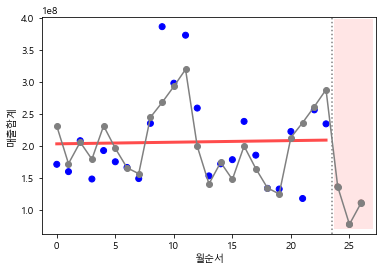

In [53]:
# 월순서와 매출합계간의 선형 추세선과 다중회귀분석을 통한 예측선 추가

colors1 = np.where(sales02p.seq<24,'blue','grey')
plt.scatter(np.arange(len(sales02p)), sales02p.amt, color=colors1)
plt.xlabel('월순서')
plt.ylabel('매출합계')
varx = np.arange(len(sales02))
vary = sales02.amt
# 선형추세선
plt.plot(np.unique(varx), np.poly1d(np.polyfit(varx, vary, 1))(np.unique(varx)), 
         color='red', linewidth=3, alpha=0.7)

# 미래기간에 대한 예측치를 포함한 추이 추가 표시
plt.plot(np.arange(len(sales02p)), sales02p['pred'], color='grey', marker='o')

plt.axvline(23.5, color='grey', linestyle=':')

# 선택영역 색상 구별
import matplotlib.patches as mpatches
left, bottom, width, height = (23.7, (1e+8)*.7, 3.3, (4e+8)*0.82)
rect=mpatches.Rectangle((left,bottom),width,height, 
                        #fill=False,
                        alpha=0.1,
                       facecolor="red")
plt.gca().add_patch(rect)

plt.show()

- [예측분석 결과] 2021년 초반의 3개월 : 계절성을 따르지만 추세상 과거에 비해 감소할 것이라는 전망치를 산출

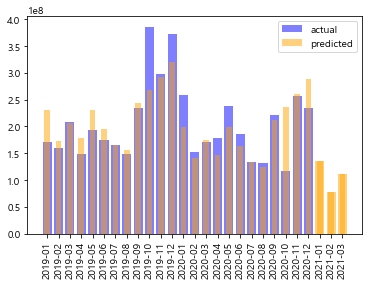

In [54]:
# 2020년 까지 2년간 실제값은 파란색으로 표시
colors1 = np.where(sales02p.seq<24,'blue','orange')

plt.bar(sales02p.saleMon, sales02p.amt, alpha=0.5, color=colors1)
# 다중회귀분석 결과는 오렌지색으로 예측치 표시
plt.bar(sales02p.saleMon, sales02p.pred, alpha=0.5, width=0.5, color='orange')
plt.xticks(rotation=90)
plt.legend(['actual', 'predicted'])
plt.show()

- 주의사항: 계절적인 변동을 적절히 반영하기 위해서는 (모델생성 즉 학습 용도로) 최소 3년간의 측정값이 필요

**다중회귀분석이 가능했던 이유 :**
- 시간순서, 연도, 월 등은 자동적으로 미래에 증가할 값을 알수 있음
- 매출계절지수 역시 월에 따라 고정되어 변화하지 않는다고 가정
- [주의] 미래의 값을 알 수 없는 변수를 예측모델의 변수(X 독립변수)로 사용하면 미래값 계산 불가능

#### 연도별 계절별 추이 비교 (**Monthly values Yearly comparisons**)

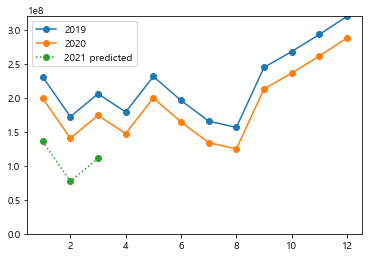

In [55]:
# 월기준으로 겹쳐서 연도별 추이를 비교하는 시각화 (Monthly values Yearly comparisons)

plt.plot(np.arange(1, 13), sales02p['pred'][:12], marker='o')
plt.plot(np.arange(1, 13), sales02p['pred'][12:24], marker='o')

# 실제값과 예측치는 구별되도록 표시 (dotted)
plt.plot(np.arange(1, 4),sales02p['pred'][24:], marker='o', linestyle=":")
plt.ylim(0,sales02p['pred'].max())
plt.legend([2019,2020,'2021 predicted'])
plt.show()

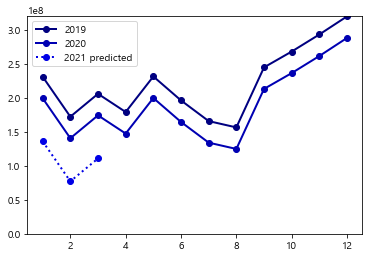

In [56]:
# 월기준으로 겹쳐서 연도별 추이를 비교하는 시각화
# 색상을 단순화하고 추이를 나타낼 수 있도록 변경

colors1 = np.array([0.5,0.7,0.9]) 
# 색상을 지정하기 위한 RGB 값에 일정한 변화를 주는 방식

plt.plot(np.arange(1, 13), sales02p['pred'][:12],
         marker='o', color=[0,0,colors1[0]], linewidth=2)
plt.plot(np.arange(1, 13), sales02p['pred'][12:24], 
         marker='o', color=[0,0,colors1[1]], linewidth=2)

# 실제값과 예측치는 구별되도록 표시 (dotted)
plt.plot(np.arange(1, 4),sales02p['pred'][24:], 
         marker='o', linestyle=":", color=[0,0,colors1[2]], linewidth=2)
plt.ylim(0,sales02p['pred'].max())
plt.legend(['2019','2020','2021 predicted'])
plt.show()

- [시각화 point] 단순화된 색상이지만 같은 **톤에서의 일정한 차이**로 인해 **추세의 변화임**을 설명하지 않아도 연도 차이를 느낄 수 있도록

### 회귀분석 - 통계 세부결과 확인 - statsmodels

In [57]:
import statsmodels.api as sm
# with statsmodels

# 독립변수 데이터 지정
X = sm.add_constant(X) 

# 종속변수 지정해 모델 생성
model = sm.OLS(y, X).fit()

# 모델을 통한 예측값 생성
predictions = model.predict(X) 
 
# 모델의 세부 결과 요약 출력
print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:                    amt   R-squared:                       0.582
Model:                            OLS   Adj. R-squared:                  0.520
Method:                 Least Squares   F-statistic:                     9.291
Date:                Tue, 10 May 2022   Prob (F-statistic):           0.000472
Time:                        21:31:14   Log-Likelihood:                -456.70
No. Observations:                  24   AIC:                             921.4
Df Residuals:                      20   BIC:                             926.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.582e+07   4.49e+07      0.352      0.7

- 모델 전체로 보면 유의
- meanMonAmt 변수만 매우 유의 - 나머지 변수들은 유의한 수준은 아님
- 월순서를 나타내는 seq의 부호 양수
- 연도의 순서인 yrSeq 음수 - 시간이 지날수록 값이 줄어드는 관계가 나타남 (기간이 짧아 매우 유의하지는 않음)
<br><br>
- 2년간 월별 집계 데이터만 투입한 결과의 한계

In [58]:
# 독립변수(X) 들 사이에 강한 상관관계가 존재하는지 (=다중공선성) 확인

round(sales05[['amt','seq', 'monSeq', 'yrSeq', 'mon', 'meanMonAmt']].corr(),3)

,amt,seq,monSeq,yrSeq,meanMonAmt
amt,1.000,0.025,0.451,-0.230,0.728
seq,0.025,1.000,0.499,0.867,0.309
monSeq,0.451,0.499,1.000,0.000,0.620
yrSeq,-0.230,0.867,0.000,1.000,-0.000
meanMonAmt,0.728,0.309,0.620,-0.000,1.000


- amt와 meanMonAmt 관계 강함 -- 월별로 금액을 평균한 것이므로 당연

<AxesSubplot:>

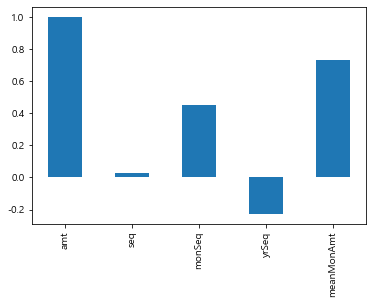

In [59]:
round(sales05[['amt','seq', 'monSeq', 'yrSeq', 'mon', 'meanMonAmt']].corr(),3).amt.plot(kind='bar')

# amt 자기 자신과의 관계는 1
# 연도순서 yrSeq 와는 반대방향의 상관관계

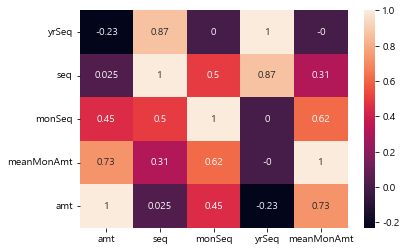

In [60]:
# 상관관계 테이블을 heatmap으로 시각화해 확인

import seaborn as sns

df4heatmap = round(sales05[['amt','seq', 'monSeq', 'yrSeq', 'mon', 'meanMonAmt']].corr(),3)
# 순서 정렬
df4heatmap = df4heatmap.sort_values('amt')
sns.heatmap(df4heatmap, annot=True)
plt.show()

#### 회귀분석의 한계와 제약
- 여러 가정을 전제로 모델 성립
- 선형성이나 다중공선성(multi-colineartity) 등 관련 가정 충족 필요
- 현실에서는 가정을 모두 충족하지 않는 경우 많음
- 결국 모델링 방식이 너무 단순해 현실의 복잡한 특성을 충분히 담지 못함
<br><br>
- 현실에 가까운 모델을 만들기 위해 근래에는 비선형모델 또는 기계학습 머신러닝 machine learning 활용 증가

# 추가 연습문제

- 셔츠, 바지 등 소분류 상품군별 2021년 1개년 월별 매출 추이를 예측하라
- 남성, 여성 각각의 고객집단별 2021년 1개년 월별 매출 추이를 예측하라
- 상품코드 기준 매출이 가장 많은 5개 상품에 대해 2021년 1개년 월별 매출 추이를 예측하라
- 점포별 2021년 1개년 월별 매출 추이를 예측하라

## Section 4 :  또 다른 가상의 매출데이터를 사용한 미래예측 예제



- 두 개 임의의 패션 브랜드를 GT Mix해 가상의 매출 데이터 생성

In [61]:
'''
tmpdfA1 = pd.read_csv(dataPath + 'a_corona.csv', encoding='euc-kr')
tmpdfA2 = pd.read_csv(dataPath + 'a_kakaoStyle.csv', encoding='euc-kr')[['kakaoStyle']]
tmpdfA3 = pd.read_csv(dataPath + 'a_musinsa.csv', encoding='euc-kr')[['musinsa']]
tmpdfA4 = pd.read_csv(dataPath + 'a_uniqlo.csv', encoding='euc-kr')[['uniqlo']]
salesu = pd.concat([tmpdfA1, tmpdfA2, tmpdfA3,tmpdfA4], axis=1)
'''

# salesu = salesu
salesu = pd.read_csv('GT_uniql_kaka.csv', encoding='euc-kr').iloc[:,1:]
# salesu.to_csv('GT_unicl_kaka.csv')

,date,corona,kakaoStyle,musinsa,uniqlo
256,2022-03-13,31.0,71,54,15
257,2022-03-20,25.0,59,49,18
258,2022-03-27,21.0,58,56,14
259,2022-04-03,17.0,42,55,19
260,2022-04-10,15.0,67,62,21


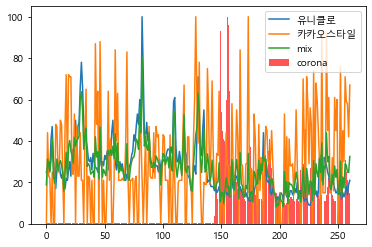

In [62]:
display(salesu.tail())
plt.plot(np.arange(len(salesu)), salesu.uniqlo)
plt.plot(np.arange(len(salesu)), salesu.kakaoStyle)
plt.plot(np.arange(len(salesu)), (salesu.kakaoStyle + (salesu.uniqlo*3))/4)
plt.bar(np.arange(len(salesu)), salesu.corona, 
        alpha=0.67, color='red')
plt.legend(['유니클로','카카오스타일','mix', 'corona'])
plt.show()

# 주단위로 집계된 검색지수

In [63]:
salesu[salesu.columns[1:]].corr()

,corona,kakaoStyle,musinsa,uniqlo
corona,1.000000,0.025458,0.206729,-0.485714
kakaoStyle,0.025458,1.000000,0.076694,-0.132802
musinsa,0.206729,0.076694,1.000000,0.056667
uniqlo,-0.485714,-0.132802,0.056667,1.000000


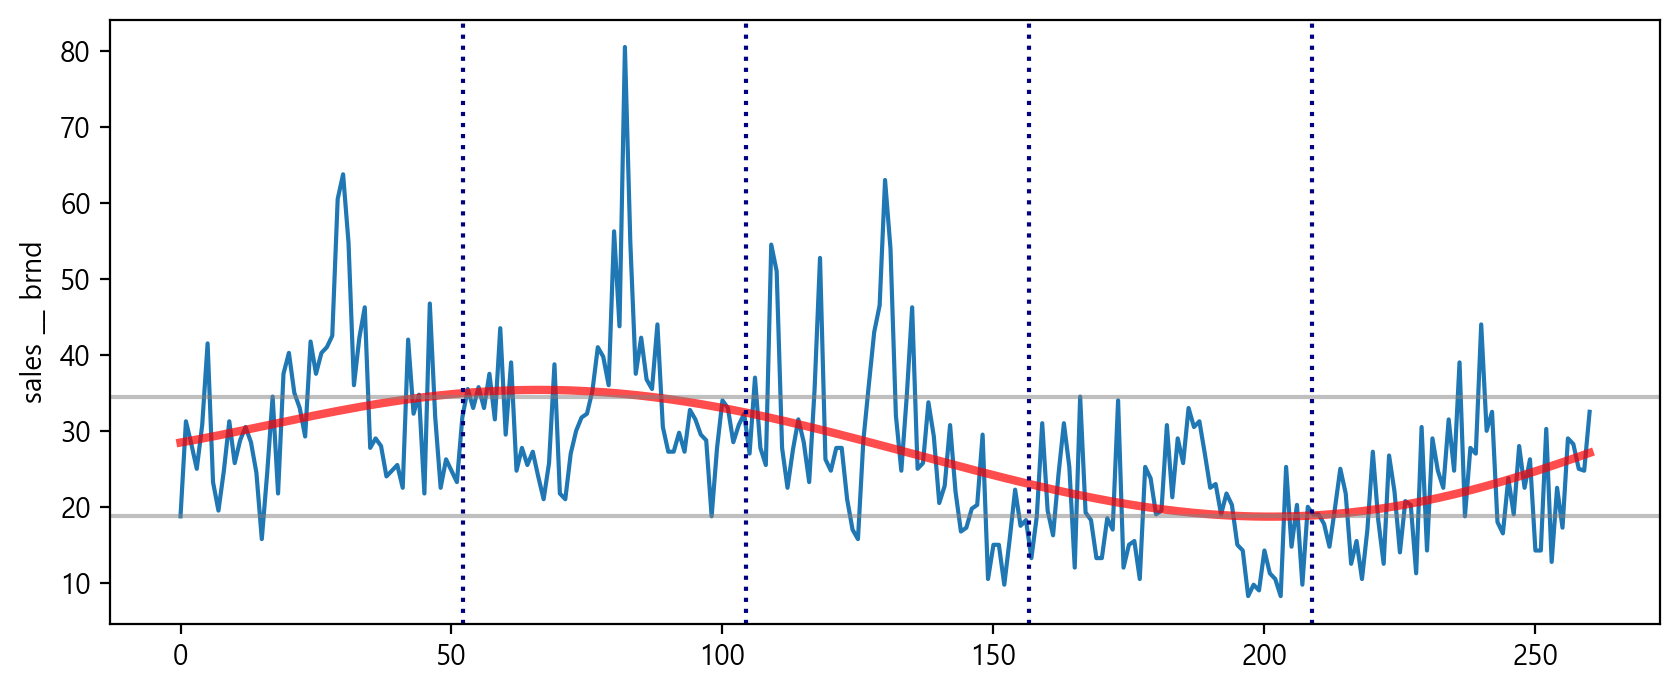

In [64]:
# a virtual series of sales for sales forecasting example

plt.figure(figsize=(10,4), dpi=200)
plt.plot(np.arange(len(salesu)), (salesu.kakaoStyle + (salesu.uniqlo*3))/4)
intervali = len(salesu)/5

varx = np.arange(len(salesu))
vary = (salesu.kakaoStyle + (salesu.uniqlo*3))/4
# 차수==1 (선형)
plt.plot(np.unique(varx), np.poly1d(np.polyfit(varx, vary, 5))(np.unique(varx)), 
         color='red', linewidth=3, alpha=0.7)

for i in np.arange(4):
    plt.axvline((i+1)*intervali , color='navy', linestyle=":" )   
plt.ylabel('sales __ brnd') 
plt.axhline(vary.quantile(0.8), color='grey', alpha=0.5)
plt.axhline(vary.quantile(0.2), color='grey', alpha=0.5)
plt.show()


- 월단위로 전환 필요

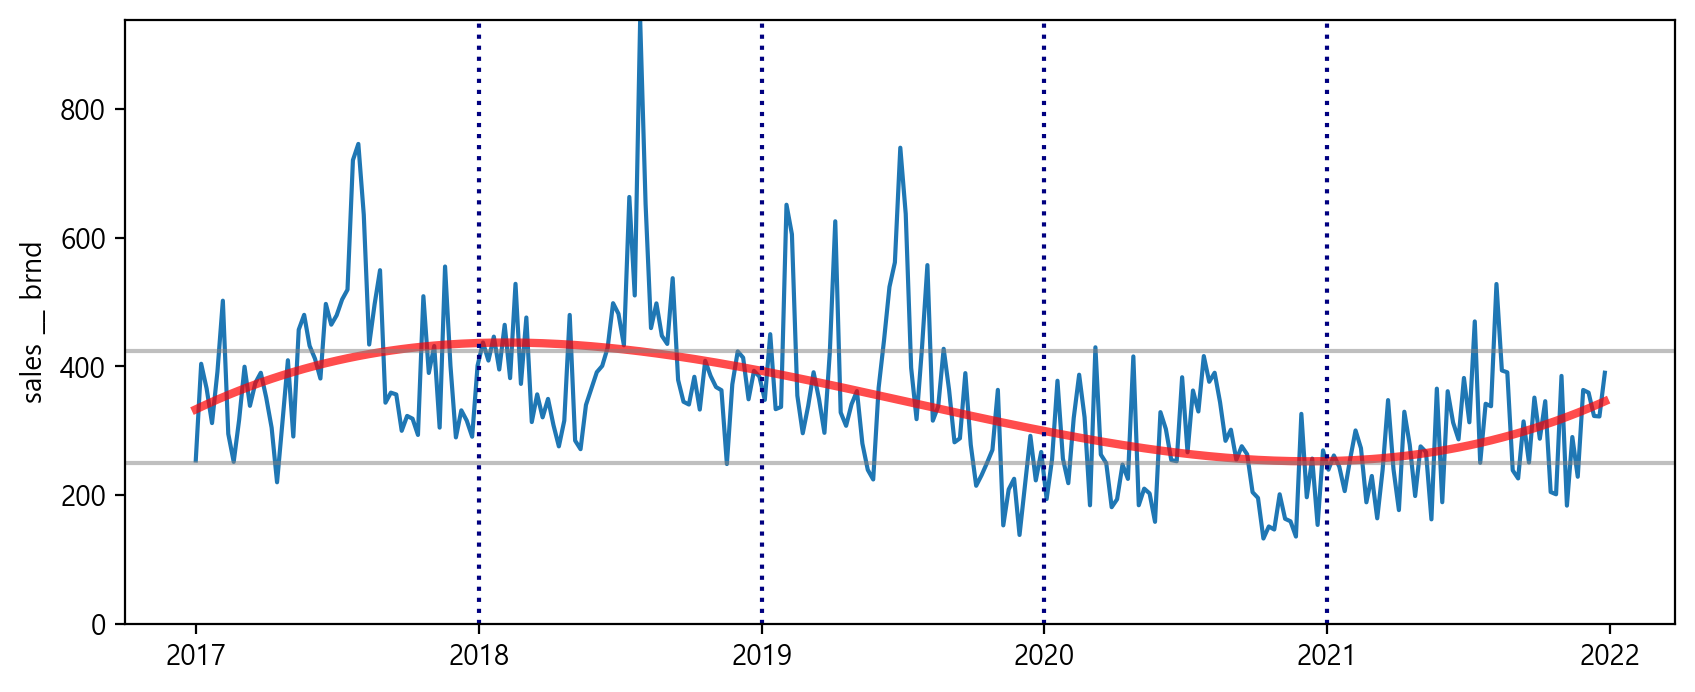

In [65]:
# a virtual series of sales for sales forecasting example

startyr = 2017
yearSeries = np.arange(len(salesu))/len(salesu)*5 +startyr
saleSeries = (salesu.kakaoStyle + (salesu.uniqlo*3))/4 + 4
saleSeries = rjitt(saleSeries)*11
salesu['saleSeries'] = saleSeries

plt.figure(figsize=(10,4), dpi=200)
plt.plot(yearSeries, saleSeries)
intervali = 1

varx = yearSeries
vary = saleSeries
# 차수==1 (선형)
plt.plot(np.unique(varx), np.poly1d(np.polyfit(varx, vary, 5))(np.unique(varx)), 
         color='red', linewidth=3, alpha=0.7)

for i in np.arange(4):
    plt.axvline(i+startyr+1 , color='navy', linestyle=":" )   
plt.ylabel('sales __ brnd') 
plt.axhline(vary.quantile(0.8), color='grey', alpha=0.5)
plt.axhline(vary.quantile(0.2), color='grey', alpha=0.5)
plt.ylim(0, np.max(saleSeries))
plt.show()


### 과제: 가상 매출 데이터의 2022년 매출 영역을 이전 데이터만을 사용해서 예측하라

In [66]:
salesu.tail()

,date,corona,kakaoStyle,musinsa,uniqlo,saleSeries
256,2022-03-13,31.0,71,54,15,363.085778
257,2022-03-20,25.0,59,49,18,358.882503
258,2022-03-27,21.0,58,56,14,322.626954
259,2022-04-03,17.0,42,55,19,321.878598
260,2022-04-10,15.0,67,62,21,389.848368


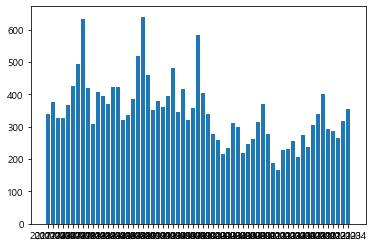

In [67]:
salesu1 = salesu.copy()
salesu1['mon'] = salesu1.date.str.slice(0,7)
salesu2 = salesu1[['mon', 'saleSeries']].groupby('mon').mean().reset_index()
plt.bar(salesu2.mon,salesu2.saleSeries)
plt.show()

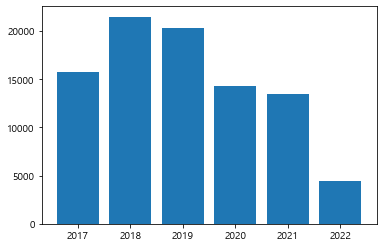

In [68]:
salesu1 = salesu.copy()
salesu1['yr'] = salesu1.date.str.slice(0,4)
salesu2 = salesu1[['yr', 'saleSeries']].groupby('yr').sum().reset_index()
plt.bar(salesu2.yr,salesu2.saleSeries)
plt.show()

In [69]:
salesu1 = salesu.copy()
print(salesu1.shape)
salesu1['mon'] = salesu1.date.str.slice(0,7)
display(salesu1.tail())

# msm : monthly sales modeling
salesu_msm = salesu1[['mon','corona', 'musinsa', 'uniqlo', 'kakaoStyle', 'saleSeries']].groupby('mon').mean().reset_index()
display(salesu_msm.tail())
print(salesu_msm.shape)

# 다음해 동월 변수 생성
salesu_msm['saleNxyr'] = np.append( salesu_msm.tail(len(salesu_msm)-12).saleSeries, np.repeat(0,12))

# 다음 달
salesu_msm['saleNxmn'] = np.append( salesu_msm.tail(len(salesu_msm)-1).saleSeries, np.repeat(0,1))
# 다다음 달
salesu_msm['saleNxmn2'] = np.append( salesu_msm.tail(len(salesu_msm)-2).saleSeries, np.repeat(0,2))
# 세번째 미래 달
salesu_msm['saleNxmn3'] = np.append( salesu_msm.tail(len(salesu_msm)-3).saleSeries, np.repeat(0,3))

# 다음 달과 다다음 달은 뒤에 사용


salesu_msm.tail()

(261, 6)


,date,corona,kakaoStyle,musinsa,uniqlo,saleSeries,mon
256,2022-03-13,31.0,71,54,15,363.085778,2022-03
257,2022-03-20,25.0,59,49,18,358.882503,2022-03
258,2022-03-27,21.0,58,56,14,322.626954,2022-03
259,2022-04-03,17.0,42,55,19,321.878598,2022-04
260,2022-04-10,15.0,67,62,21,389.848368,2022-04


,mon,corona,musinsa,uniqlo,kakaoStyle,saleSeries
56,2021-12,19.25,48.75,20.0,30.75,292.112797
57,2022-01,14.60,45.80,17.2,36.40,287.799083
58,2022-02,23.00,55.25,14.0,37.75,264.757336
59,2022-03,25.75,53.00,15.0,54.50,318.194482
60,2022-04,16.00,58.50,20.0,54.50,355.863483


(61, 6)


,mon,corona,musinsa,uniqlo,kakaoStyle,saleSeries,saleNxyr,saleNxmn,saleNxmn2,saleNxmn3
56,2021-12,19.25,48.75,20.0,30.75,292.112797,0.0,287.799083,264.757336,318.194482
57,2022-01,14.60,45.80,17.2,36.40,287.799083,0.0,264.757336,318.194482,355.863483
58,2022-02,23.00,55.25,14.0,37.75,264.757336,0.0,318.194482,355.863483,0.000000
59,2022-03,25.75,53.00,15.0,54.50,318.194482,0.0,355.863483,0.000000,0.000000
60,2022-04,16.00,58.50,20.0,54.50,355.863483,0.0,0.000000,0.000000,0.000000


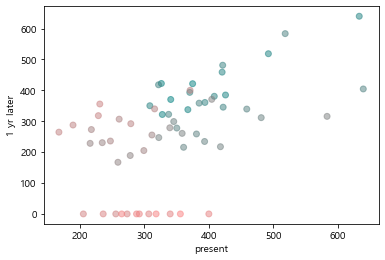

In [70]:
colors1 = [[x/len(salesu_msm),0.5,0.5] for x in salesu_msm.index] 
# colors1 = np.where(salesu_msm.saleNxyr==0,[1,1,1],colors1)
plt.scatter(salesu_msm.saleSeries, salesu_msm.saleNxyr,
           alpha=0.5,
           color=colors1)
plt.xlabel('present')
plt.ylabel('1 yr later')
plt.show()

### 다중회귀분석 적용
- 다중회귀분석 multiple regression analysis는 다수의 독립변수 X = {X1,X2,...Xn}를 사용해서 종속변수 Y를 추측하는 모델링

In [71]:
sales03 = salesu_msm.copy().tail(60)
display(salesu_msm.tail())

mons = np.array(sales03.mon)

# 시간적인 순서를 일련번호로
sales03['seq'] = np.arange(len(sales03))
print(sales03.shape)

# 월의 순서를 일련번호로 - 연도가 다르면 다시 시작
monSeqs = np.array(pd.DataFrame(np.array([np.arange(12)]+[np.arange(12)]+[np.arange(12)]+[np.arange(12)]+[np.arange(12)]+[np.arange(12)]).flatten()).tail(68).head(60))
sales03['monSeq'] = monSeqs 

# 연도의 순서를 일련 번호로
sales03['yrSeq'] = np.repeat([0,1,2,3,4,5],12)[2:][:60]
sales03.tail()

,mon,corona,musinsa,uniqlo,kakaoStyle,saleSeries,saleNxyr,saleNxmn,saleNxmn2,saleNxmn3
56,2021-12,19.25,48.75,20.0,30.75,292.112797,0.0,287.799083,264.757336,318.194482
57,2022-01,14.60,45.80,17.2,36.40,287.799083,0.0,264.757336,318.194482,355.863483
58,2022-02,23.00,55.25,14.0,37.75,264.757336,0.0,318.194482,355.863483,0.000000
59,2022-03,25.75,53.00,15.0,54.50,318.194482,0.0,355.863483,0.000000,0.000000
60,2022-04,16.00,58.50,20.0,54.50,355.863483,0.0,0.000000,0.000000,0.000000


(60, 11)


,mon,corona,musinsa,uniqlo,kakaoStyle,saleSeries,saleNxyr,saleNxmn,saleNxmn2,saleNxmn3,seq,monSeq,yrSeq
56,2021-12,19.25,48.75,20.0,30.75,292.112797,0.0,287.799083,264.757336,318.194482,55,11,4
57,2022-01,14.60,45.80,17.2,36.40,287.799083,0.0,264.757336,318.194482,355.863483,56,0,4
58,2022-02,23.00,55.25,14.0,37.75,264.757336,0.0,318.194482,355.863483,0.000000,57,1,4
59,2022-03,25.75,53.00,15.0,54.50,318.194482,0.0,355.863483,0.000000,0.000000,58,2,5
60,2022-04,16.00,58.50,20.0,54.50,355.863483,0.0,0.000000,0.000000,0.000000,59,3,5


,mon,meanMonAmt
0,01,0.577134
1,02,0.604314
2,03,0.619429
3,04,0.647122
4,05,0.753329
5,06,0.652622
6,07,0.636341
7,08,0.616726
8,09,0.709232
9,10,0.918974


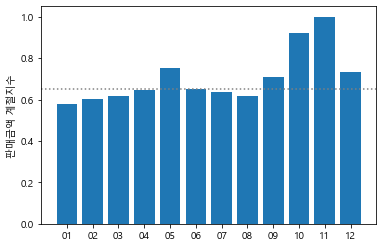

In [72]:
# 월의 순서만으로는 매출의 계절성을 표현하기 어려우므로
# 계절성을 명시적으로 보여주는 변수를 생성해 모델링에 추가
# adding a derived feature

sales04 = sales03.copy()
sales04['mon'] = sales04.mon.str.slice(5,7)
sales04m = sales04[['mon','saleSeries']].groupby('mon').mean().reset_index()
sales04m.columns = ['mon', 'meanMonAmt']

# 계절의 매출지수를 변수로 추가
sales04m['meanMonAmt'] = zrmx_scl(sales04m['meanMonAmt'])
display(sales04m)

plt.bar(sales04m.mon, sales04m.meanMonAmt)
plt.ylabel('판매금액 계절지수')
plt.axhline(sales04m.meanMonAmt.median(), color='grey', linestyle=':')
plt.show()

In [73]:
sales05 = sales04.merge(sales04m, how='left', on='mon')
# 누적평균 변수생성
sales05['coronaCummean'] = sales05.corona.expanding().mean()
sales05.tail()

,mon,corona,musinsa,uniqlo,kakaoStyle,saleSeries,saleNxyr,saleNxmn,saleNxmn2,saleNxmn3,seq,monSeq,yrSeq,meanMonAmt,coronaCummean
55,12,19.25,48.75,20.0,30.75,292.112797,0.0,287.799083,264.757336,318.194482,55,11,4,0.730866,9.850000
56,01,14.60,45.80,17.2,36.40,287.799083,0.0,264.757336,318.194482,355.863483,56,0,4,0.577134,9.933333
57,02,23.00,55.25,14.0,37.75,264.757336,0.0,318.194482,355.863483,0.000000,57,1,4,0.604314,10.158621
58,03,25.75,53.00,15.0,54.50,318.194482,0.0,355.863483,0.000000,0.000000,58,2,5,0.619429,10.422881
59,04,16.00,58.50,20.0,54.50,355.863483,0.0,0.000000,0.000000,0.000000,59,3,5,0.647122,10.515833


In [74]:
sales05.columns

Index(['mon', 'corona', 'musinsa', 'uniqlo', 'kakaoStyle', 'saleSeries',
       'saleNxyr', 'saleNxmn', 'saleNxmn2', 'saleNxmn3', 'seq', 'monSeq',
       'yrSeq', 'meanMonAmt', 'coronaCummean'],
      dtype='object')

In [75]:
from sklearn.linear_model import LinearRegression

# 판매금액계절지수 추가 변수를 포함해서 다음해 동월을 예측하는 모델 생성
feats = ['saleSeries','monSeq','yrSeq', 'meanMonAmt','corona','coronaCummean','musinsa','uniqlo', 'kakaoStyle']
X = sales05.head(48)[feats]
y = sales05.head(48).saleNxyr
reg = LinearRegression().fit(X, y)

reg.score(X, y) # 결정계수 R2

0.806935784439095

In [76]:
sales05['predSales'] = np.array(reg.predict(sales05[feats]))
sales05['yrmon'] = mons 
display(sales05.head())
sales05.tail()

,mon,corona,musinsa,uniqlo,kakaoStyle,saleSeries,saleNxyr,saleNxmn,saleNxmn2,saleNxmn3,seq,monSeq,yrSeq,meanMonAmt,coronaCummean,predSales,yrmon
0,05,0.5,23.50,36.25,11.75,374.919302,421.637087,326.366627,327.838394,367.511683,0,4,0,0.753329,0.5,499.304994,2017-05
1,06,0.5,22.25,23.75,30.00,326.366627,422.356873,327.838394,367.511683,426.016588,1,5,0,0.652622,0.5,425.171863,2017-06
2,07,0.5,25.00,24.40,29.20,327.838394,321.960482,367.511683,426.016588,492.615144,2,6,0,0.636341,0.5,399.625365,2017-07
3,08,0.5,27.75,21.50,53.75,367.511683,337.640522,426.016588,492.615144,633.754297,3,7,0,0.616726,0.5,346.327657,2017-08
4,09,0.5,36.00,30.00,47.50,426.016588,385.014540,492.615144,633.754297,420.748800,4,8,0,0.709232,0.5,385.708872,2017-09


,mon,corona,musinsa,uniqlo,kakaoStyle,saleSeries,saleNxyr,saleNxmn,saleNxmn2,saleNxmn3,seq,monSeq,yrSeq,meanMonAmt,coronaCummean,predSales,yrmon
55,12,19.25,48.75,20.0,30.75,292.112797,0.0,287.799083,264.757336,318.194482,55,11,4,0.730866,9.850000,298.951328,2021-12
56,01,14.60,45.80,17.2,36.40,287.799083,0.0,264.757336,318.194482,355.863483,56,0,4,0.577134,9.933333,237.302906,2022-01
57,02,23.00,55.25,14.0,37.75,264.757336,0.0,318.194482,355.863483,0.000000,57,1,4,0.604314,10.158621,201.310917,2022-02
58,03,25.75,53.00,15.0,54.50,318.194482,0.0,355.863483,0.000000,0.000000,58,2,5,0.619429,10.422881,175.069394,2022-03
59,04,16.00,58.50,20.0,54.50,355.863483,0.0,0.000000,0.000000,0.000000,59,3,5,0.647122,10.515833,174.371121,2022-04


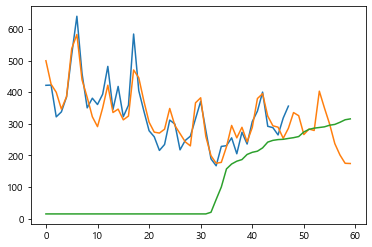

In [77]:
plt.plot(sales05.head(48).saleNxyr)
plt.plot(sales05.predSales)
plt.plot(sales05.coronaCummean*30)
plt.show()

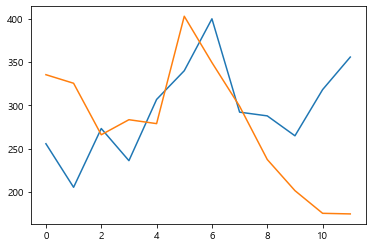

In [78]:
plt.plot(np.array(sales05.tail(12).saleSeries))
plt.plot(np.array(sales05.tail(12).predSales))

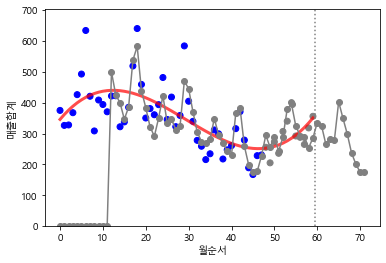

In [79]:
# 월순서와 매출합계간의 선형, polynomial 회귀선 추가
sales02p = sales05.copy()
sales02p['pred'] = reg.predict(sales02p[feats])
colors1 = np.where(sales02p.seq<48,'blue','grey')
plt.scatter(np.arange(len(sales02p)), sales02p.saleSeries, color=colors1)
plt.xlabel('월순서')
plt.ylabel('매출합계')
varx = np.arange(len(sales02p))
vary = sales02p.saleSeries
plt.plot(np.unique(varx), np.poly1d(np.polyfit(varx, vary, 3))(np.unique(varx)), 
         color='red', linewidth=3, alpha=0.7)
plt.axvline(59.5, color='grey', linestyle=':')

# 미래기간에 대한 예측치를 포함한 추이 추가 표시
plt.plot(np.arange(len(sales02p)+12), list(np.repeat(0,12)) + list(sales02p['pred']), color='grey', marker='o')
plt.ylim(0,sales02p.saleSeries.max()*1.1)
plt.show()

- [예측분석 결과] 2022년 어느 정도는 반등한다는 전망치를 산출

,mon,corona,musinsa,uniqlo,kakaoStyle,saleSeries,saleNxyr,saleNxmn,saleNxmn2,saleNxmn3,seq,monSeq,yrSeq,meanMonAmt,coronaCummean,predSales,yrmon,pred
55,12,19.25,48.75,20.0,30.75,292.112797,0.0,287.799083,264.757336,318.194482,55,11,4,0.730866,9.850000,298.951328,2021-12,298.951328
56,01,14.60,45.80,17.2,36.40,287.799083,0.0,264.757336,318.194482,355.863483,56,0,4,0.577134,9.933333,237.302906,2022-01,237.302906
57,02,23.00,55.25,14.0,37.75,264.757336,0.0,318.194482,355.863483,0.000000,57,1,4,0.604314,10.158621,201.310917,2022-02,201.310917
58,03,25.75,53.00,15.0,54.50,318.194482,0.0,355.863483,0.000000,0.000000,58,2,5,0.619429,10.422881,175.069394,2022-03,175.069394
59,04,16.00,58.50,20.0,54.50,355.863483,0.0,0.000000,0.000000,0.000000,59,3,5,0.647122,10.515833,174.371121,2022-04,174.371121


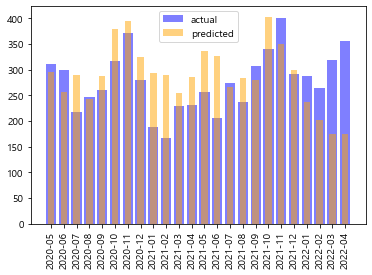

In [80]:
# 2020년 까지 2년간 실제값은 파란색으로 표시

sales02pa = sales02p.tail(24)
colors1 = np.where(sales02p.seq<48,'blue','orange')

display(sales02pa.tail())

plt.bar(sales02pa.yrmon, sales02pa.saleSeries, alpha=0.5, color=colors1)
# 다중회귀분석 결과는 오렌지색으로 예측치 표시
plt.bar(sales02pa.yrmon, sales02pa.pred, alpha=0.5, width=0.5, color='orange')
plt.xticks(rotation=90)
plt.legend(['actual', 'predicted'])
plt.show()

- 주의사항: 계절적인 변동을 적절히 반영하기 위해서는 (모델생성 즉 학습 용도로) 최소 3년간의 측정값이 필요

#### 연도별 계절별 추이 비교 (**Monthly values Yearly comparisons**)

In [81]:
# 월기준으로 겹쳐서 연도별 추이를 비교하는 시각화 (Monthly values Yearly comparisons)


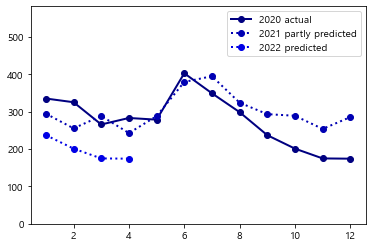

In [82]:
# 월기준으로 겹쳐서 연도별 추이를 비교하는 시각화
# 색상을 단순화하고 추이를 나타낼 수 있도록 변경

colors1 = np.array([0.5,0.7,0.9]) 
# 색상을 지정하기 위한 RGB 값에 일정한 변화를 주는 방식


plt.plot(np.arange(1, 13), sales02p.tail(12)['pred'],
         marker='o', color=[0,0,colors1[0]], linewidth=2)
plt.plot(np.arange(1, 13), sales02p.tail(24).head(12)['pred'],
         marker='o', linestyle=":",color=[0,0,colors1[1]], linewidth=2)

# 실제값과 예측치는 구별되도록 표시 (dotted)
plt.plot(np.arange(1, 5), sales02p.tail(4)['pred'],
         marker='o', linestyle=":", color=[0,0,colors1[2]], linewidth=2)
plt.ylim(0,sales02p['pred'].max())
plt.legend(['2020 actual','2021 partly predicted','2022 predicted'])
plt.show()

**[ Considerations ]**
- 다음해 동월을 예측하는 모델을 사용하게되면 가까운 미래 구간에 대해서는 최신 데이터가 존재함에도 사용하지 않는 문제 발생
- 12개 모델을 만드는 방식 고려 필요
- 정밀한 예측을 위해 복잡하게 모델을 만들 것인지 정밀함을 희생하고 단순하게 할 것인지 판단 필요

### 각 월별 별도 모델을 활용하는 예측

In [83]:
from sklearn.linear_model import LinearRegression

# 판매금액계절지수 추가 변수를 포함해서 다음달을 예측하는 모델 생성
feats = ['saleSeries','monSeq','yrSeq', 'meanMonAmt','corona','coronaCummean','musinsa','uniqlo', 'kakaoStyle']
X = sales05.head(59)[feats]
y = sales05.head(59).saleNxmn
reg = LinearRegression().fit(X, y)

reg.score(X,y)

0.49476189362151524

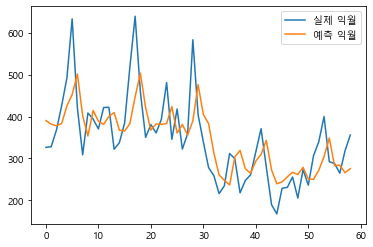

In [84]:
plt.plot(y)
plt.plot(reg.predict(X))
plt.legend(['실제 익월', '예측 익월'])
plt.show()

- 정확도가 낮은 이유는 다음 달의 특성을 충분히 반영해주지 않았기 때문 (X features)
- 예측결과가 전달의 값에 의존하는듯한 양상

In [85]:
sales05.head(59).tail(3)

,mon,corona,musinsa,uniqlo,kakaoStyle,saleSeries,saleNxyr,saleNxmn,saleNxmn2,saleNxmn3,seq,monSeq,yrSeq,meanMonAmt,coronaCummean,predSales,yrmon
56,01,14.60,45.80,17.2,36.40,287.799083,0.0,264.757336,318.194482,355.863483,56,0,4,0.577134,9.933333,237.302906,2022-01
57,02,23.00,55.25,14.0,37.75,264.757336,0.0,318.194482,355.863483,0.000000,57,1,4,0.604314,10.158621,201.310917,2022-02
58,03,25.75,53.00,15.0,54.50,318.194482,0.0,355.863483,0.000000,0.000000,58,2,5,0.619429,10.422881,175.069394,2022-03


### 각 예측대상 월별 모델 개발

In [86]:
# 다음 달의 월, 연도 순번과 계절지수 추출

dfnxmonFeats = sales05.tail(59)[['monSeq', 'yrSeq', 'meanMonAmt']].copy().reset_index(drop=True)
dfnxmonFeats.columns = list(dfnxmonFeats.columns + '_nxmn')
dfnxmonFeats.tail()

,monSeq_nxmn,yrSeq_nxmn,meanMonAmt_nxmn
54,11,4,0.730866
55,0,4,0.577134
56,1,4,0.604314
57,2,5,0.619429
58,3,5,0.647122


In [87]:
# 다음 달에 대한 변수를 결합

dfnxmnSfcst1 = sales05.head(59)[feats + ['saleNxmn']]
display(dfnxmnSfcst1.tail())
# 다음 달의 값을 옆으로 결합해 줌
dfnxmnSfcst1 = pd.concat([dfnxmnSfcst1, dfnxmonFeats], axis=1)
dfnxmnSfcst1.tail()

,saleSeries,monSeq,yrSeq,meanMonAmt,corona,coronaCummean,musinsa,uniqlo,kakaoStyle,saleNxmn
54,400.122724,10,4,1.000000,13.50,9.679091,77.00,29.0,41.75,292.112797
55,292.112797,11,4,0.730866,19.25,9.850000,48.75,20.0,30.75,287.799083
56,287.799083,0,4,0.577134,14.60,9.933333,45.80,17.2,36.40,264.757336
57,264.757336,1,4,0.604314,23.00,10.158621,55.25,14.0,37.75,318.194482
58,318.194482,2,5,0.619429,25.75,10.422881,53.00,15.0,54.50,355.863483


,saleSeries,monSeq,yrSeq,meanMonAmt,corona,coronaCummean,musinsa,uniqlo,kakaoStyle,saleNxmn,monSeq_nxmn,yrSeq_nxmn,meanMonAmt_nxmn
54,400.122724,10,4,1.000000,13.50,9.679091,77.00,29.0,41.75,292.112797,11,4,0.730866
55,292.112797,11,4,0.730866,19.25,9.850000,48.75,20.0,30.75,287.799083,0,4,0.577134
56,287.799083,0,4,0.577134,14.60,9.933333,45.80,17.2,36.40,264.757336,1,4,0.604314
57,264.757336,1,4,0.604314,23.00,10.158621,55.25,14.0,37.75,318.194482,2,5,0.619429
58,318.194482,2,5,0.619429,25.75,10.422881,53.00,15.0,54.50,355.863483,3,5,0.647122


In [88]:
from sklearn.linear_model import LinearRegression

# 판매금액계절지수 추가 변수를 포함해서 다음달을 예측하는 모델 생성
feats = ['saleSeries','monSeq','yrSeq', 'meanMonAmt','corona','coronaCummean','musinsa','uniqlo', 'kakaoStyle', 'monSeq_nxmn', 'yrSeq_nxmn', 'meanMonAmt_nxmn']
X = dfnxmnSfcst1[feats]
y = dfnxmnSfcst1.saleNxmn
reg1 = LinearRegression().fit(X, y)

reg1.score(X,y)

# 결정계수값 대폭 증가 - 이미 알고 있는 미래의 월 순서와 금액을 추가로 투입했기 때문

0.788462508594532

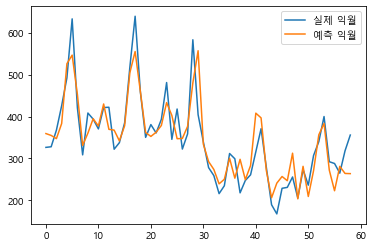

In [89]:
plt.plot(y)
plt.plot(reg1.predict(X))
plt.legend(['실제 익월', '예측 익월'])
plt.show()

In [90]:
# 다다음 달의 월, 연도 순번과 계절지수 추출

dfnxmonFeats2 = sales05.tail(58)[['monSeq', 'yrSeq', 'meanMonAmt']].copy().reset_index(drop=True)
dfnxmonFeats2.columns = list(dfnxmonFeats2.columns + '_nxmn2')
dfnxmonFeats2.tail()

# 다다음 달에 대한 변수를 결합한 테이블 생성
feats = ['saleSeries','monSeq','yrSeq', 'meanMonAmt','corona','coronaCummean','musinsa','uniqlo', 'kakaoStyle']
dfnxmn2Sfcst = sales05.head(58)[['yrmon'] + feats + ['saleNxmn2']]
display(dfnxmn2Sfcst.tail())
dfnxmn2Sfcst = pd.concat([dfnxmn2Sfcst, dfnxmonFeats2], axis=1)
dfnxmn2Sfcst.tail()

,yrmon,saleSeries,monSeq,yrSeq,meanMonAmt,corona,coronaCummean,musinsa,uniqlo,kakaoStyle,saleNxmn2
53,2021-10,340.052266,9,4,0.918974,13.20,9.608333,51.60,24.2,36.60,292.112797
54,2021-11,400.122724,10,4,1.000000,13.50,9.679091,77.00,29.0,41.75,287.799083
55,2021-12,292.112797,11,4,0.730866,19.25,9.850000,48.75,20.0,30.75,264.757336
56,2022-01,287.799083,0,4,0.577134,14.60,9.933333,45.80,17.2,36.40,318.194482
57,2022-02,264.757336,1,4,0.604314,23.00,10.158621,55.25,14.0,37.75,355.863483


,yrmon,saleSeries,monSeq,yrSeq,meanMonAmt,corona,coronaCummean,musinsa,uniqlo,kakaoStyle,saleNxmn2,monSeq_nxmn2,yrSeq_nxmn2,meanMonAmt_nxmn2
53,2021-10,340.052266,9,4,0.918974,13.20,9.608333,51.60,24.2,36.60,292.112797,11,4,0.730866
54,2021-11,400.122724,10,4,1.000000,13.50,9.679091,77.00,29.0,41.75,287.799083,0,4,0.577134
55,2021-12,292.112797,11,4,0.730866,19.25,9.850000,48.75,20.0,30.75,264.757336,1,4,0.604314
56,2022-01,287.799083,0,4,0.577134,14.60,9.933333,45.80,17.2,36.40,318.194482,2,5,0.619429
57,2022-02,264.757336,1,4,0.604314,23.00,10.158621,55.25,14.0,37.75,355.863483,3,5,0.647122


In [91]:
from sklearn.linear_model import LinearRegression

# 판매금액계절지수 추가 변수를 포함해서 다다음 달 값을 예측하는 모델 생성
feats2 = ['saleSeries','monSeq','yrSeq', 'meanMonAmt','corona','coronaCummean','musinsa','uniqlo', 'kakaoStyle', 'monSeq_nxmn2', 'yrSeq_nxmn2', 'meanMonAmt_nxmn2']
X = dfnxmn2Sfcst[feats2]
y = dfnxmn2Sfcst.saleNxmn2
reg2 = LinearRegression().fit(X, y)

reg2.score(X,y)

0.7799080028144163

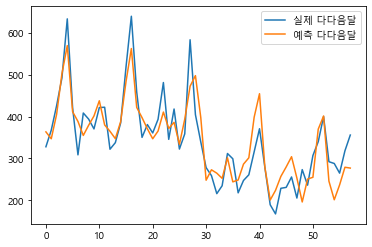

In [92]:
plt.plot(y)
plt.plot(reg2.predict(X))
plt.legend(['실제 다다음달', '예측 다다음달'])
plt.show()

In [93]:
# 다다음 달의 월, 연도 순번과 계절지수 추출

dfnxmonFeats3 = sales05.tail(57)[['monSeq', 'yrSeq', 'meanMonAmt']].copy().reset_index(drop=True)
dfnxmonFeats3.columns = list(dfnxmonFeats3.columns + '_nxmn3')
dfnxmonFeats3.tail()

# 다다음 달에 대한 변수를 결합한 테이블 생성
feats = ['saleSeries','monSeq','yrSeq', 'meanMonAmt','corona','coronaCummean','musinsa','uniqlo', 'kakaoStyle']
dfnxmn3Sfcst = sales05.head(57)[['yrmon'] + feats + ['saleNxmn3']]
display(dfnxmn3Sfcst.tail())
dfnxmn3Sfcst = pd.concat([dfnxmn3Sfcst, dfnxmonFeats3], axis=1)
dfnxmn3Sfcst.tail()

,yrmon,saleSeries,monSeq,yrSeq,meanMonAmt,corona,coronaCummean,musinsa,uniqlo,kakaoStyle,saleNxmn3
52,2021-09,306.813636,8,4,0.709232,16.25,9.540566,43.75,14.75,54.25,292.112797
53,2021-10,340.052266,9,4,0.918974,13.20,9.608333,51.60,24.20,36.60,287.799083
54,2021-11,400.122724,10,4,1.000000,13.50,9.679091,77.00,29.00,41.75,264.757336
55,2021-12,292.112797,11,4,0.730866,19.25,9.850000,48.75,20.00,30.75,318.194482
56,2022-01,287.799083,0,4,0.577134,14.60,9.933333,45.80,17.20,36.40,355.863483


,yrmon,saleSeries,monSeq,yrSeq,meanMonAmt,corona,coronaCummean,musinsa,uniqlo,kakaoStyle,saleNxmn3,monSeq_nxmn3,yrSeq_nxmn3,meanMonAmt_nxmn3
52,2021-09,306.813636,8,4,0.709232,16.25,9.540566,43.75,14.75,54.25,292.112797,11,4,0.730866
53,2021-10,340.052266,9,4,0.918974,13.20,9.608333,51.60,24.20,36.60,287.799083,0,4,0.577134
54,2021-11,400.122724,10,4,1.000000,13.50,9.679091,77.00,29.00,41.75,264.757336,1,4,0.604314
55,2021-12,292.112797,11,4,0.730866,19.25,9.850000,48.75,20.00,30.75,318.194482,2,5,0.619429
56,2022-01,287.799083,0,4,0.577134,14.60,9.933333,45.80,17.20,36.40,355.863483,3,5,0.647122


In [94]:
from sklearn.linear_model import LinearRegression

# 판매금액계절지수 추가 변수를 포함해서 다다음 달 값을 예측하는 모델 생성
feats3 = ['saleSeries','monSeq','yrSeq', 'meanMonAmt','corona','coronaCummean','musinsa','uniqlo', 'kakaoStyle', 'monSeq_nxmn3', 'yrSeq_nxmn3', 'meanMonAmt_nxmn3']
X = dfnxmn3Sfcst[feats3]
y = dfnxmn3Sfcst.saleNxmn3
reg3 = LinearRegression().fit(X, y)

reg3.score(X,y)

0.7967857151892052

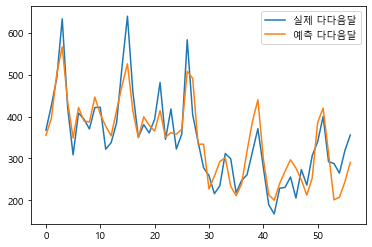

In [95]:
plt.plot(y)
plt.plot(reg3.predict(X))
plt.legend(['실제 다다음달', '예측 다다음달'])
plt.show()

In [96]:
import statsmodels.api as sm

X = sm.add_constant(X) 
model = sm.OLS(y, X).fit()
predictions = model.predict(X) 
 
print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:              saleNxmn3   R-squared:                       0.797
Model:                            OLS   Adj. R-squared:                  0.741
Method:                 Least Squares   F-statistic:                     14.38
Date:                Tue, 10 May 2022   Prob (F-statistic):           1.63e-11
Time:                        21:31:17   Log-Likelihood:                -298.83
No. Observations:                  57   AIC:                             623.7
Df Residuals:                      44   BIC:                             650.2
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const              316.8176    229.201  

In [97]:
# 변수들간의 상관관계를 구한 후
# 조합별로 표시하도록 unstack
corrTbl = dfnxmn3Sfcst[feats3 + ['saleNxmn3']].corr().unstack().reset_index()

# 자기자신과 상관관계나 절대값이 작은 조합은 제외
corrTbl[(corrTbl[0].abs()>0.6) & (corrTbl[0].abs()<1)].sort_values(0)

# 상관관계가 강한 변수 조합들이 많음 ( 다중공선성 존재)

,level_0,level_1,0
137,yrSeq_nxmn3,uniqlo,-0.627105
101,uniqlo,yrSeq_nxmn3,-0.627105
10,saleSeries,yrSeq_nxmn3,-0.626821
130,yrSeq_nxmn3,saleSeries,-0.626821
72,coronaCummean,uniqlo,-0.619023
96,uniqlo,coronaCummean,-0.619023
5,saleSeries,coronaCummean,-0.605836
65,coronaCummean,saleSeries,-0.605836
81,musinsa,meanMonAmt,0.615176
45,meanMonAmt,musinsa,0.615176


### 예측값 산출용 테이블 준비

In [98]:
df2predict = sales05[['yrmon', 'monSeq', 'yrSeq']]
df2predict.tail()

,yrmon,monSeq,yrSeq
55,2021-12,11,4
56,2022-01,0,4
57,2022-02,1,4
58,2022-03,2,5
59,2022-04,3,5


In [99]:
df2predF = pd.DataFrame([['2022-05',4,5], ['2022-06',5,5], ['2022-07',6,5]])
df2predF.columns = df2predict.columns
df2predF

,yrmon,monSeq,yrSeq
0,2022-05,4,5
1,2022-06,5,5
2,2022-07,6,5


In [100]:
df2predict = pd.concat([df2predict,df2predF])
df2predict.reset_index(drop=True, inplace=True)
df2predict.tail()

,yrmon,monSeq,yrSeq
58,2022-03,2,5
59,2022-04,3,5
60,2022-05,4,5
61,2022-06,5,5
62,2022-07,6,5


In [101]:
df2predict['mon'] = df2predict['yrmon'].str.slice(5,7)

df2predict = df2predict.merge(sales04m[['mon', 'meanMonAmt']], how='left', on='mon')
df2predict.tail()

,yrmon,monSeq,yrSeq,mon,meanMonAmt
58,2022-03,2,5,03,0.619429
59,2022-04,3,5,04,0.647122
60,2022-05,4,5,05,0.753329
61,2022-06,5,5,06,0.652622
62,2022-07,6,5,07,0.636341


In [102]:
# 다음 행의 같은 컬럼 값을 컬럼으로 추가

df2predict['monSeq_nxmn'] = df2predict['monSeq'].shift(-1)
df2predict['monSeq_nxmn2'] = df2predict['monSeq'].shift(-2)
df2predict['monSeq_nxmn3'] = df2predict['monSeq'].shift(-3)
df2predict['yrSeq_nxmn'] = df2predict['yrSeq'].shift(-1)
df2predict['yrSeq_nxmn2'] = df2predict['yrSeq'].shift(-2)
df2predict['yrSeq_nxmn3'] = df2predict['yrSeq'].shift(-3)
df2predict['meanMonAmt_nxmn'] = df2predict['meanMonAmt'].shift(-1)
df2predict['meanMonAmt_nxmn2'] = df2predict['meanMonAmt'].shift(-2)
df2predict['meanMonAmt_nxmn3'] = df2predict['meanMonAmt'].shift(-3)

df2predict.tail()

,yrmon,monSeq,yrSeq,mon,meanMonAmt,monSeq_nxmn,monSeq_nxmn2,monSeq_nxmn3,yrSeq_nxmn,yrSeq_nxmn2,yrSeq_nxmn3,meanMonAmt_nxmn,meanMonAmt_nxmn2,meanMonAmt_nxmn3
58,2022-03,2,5,03,0.619429,3.0,4.0,5.0,5.0,5.0,5.0,0.647122,0.753329,0.652622
59,2022-04,3,5,04,0.647122,4.0,5.0,6.0,5.0,5.0,5.0,0.753329,0.652622,0.636341
60,2022-05,4,5,05,0.753329,5.0,6.0,NaN,5.0,5.0,NaN,0.652622,0.636341,NaN
61,2022-06,5,5,06,0.652622,6.0,NaN,NaN,5.0,NaN,NaN,0.636341,NaN,NaN
62,2022-07,6,5,07,0.636341,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [103]:
df2predict = df2predict.merge(sales05[['yrmon', 'saleSeries', 'corona', 'coronaCummean', 'musinsa', 'uniqlo', 'kakaoStyle']], how='left', on='yrmon')
df2predict.tail()

,yrmon,monSeq,yrSeq,mon,meanMonAmt,monSeq_nxmn,monSeq_nxmn2,monSeq_nxmn3,yrSeq_nxmn,yrSeq_nxmn2,yrSeq_nxmn3,meanMonAmt_nxmn,meanMonAmt_nxmn2,meanMonAmt_nxmn3,saleSeries,corona,coronaCummean,musinsa,uniqlo,kakaoStyle
58,2022-03,2,5,03,0.619429,3.0,4.0,5.0,5.0,5.0,5.0,0.647122,0.753329,0.652622,318.194482,25.75,10.422881,53.0,15.0,54.5
59,2022-04,3,5,04,0.647122,4.0,5.0,6.0,5.0,5.0,5.0,0.753329,0.652622,0.636341,355.863483,16.00,10.515833,58.5,20.0,54.5
60,2022-05,4,5,05,0.753329,5.0,6.0,NaN,5.0,5.0,NaN,0.652622,0.636341,NaN,NaN,NaN,NaN,NaN,NaN,NaN
61,2022-06,5,5,06,0.652622,6.0,NaN,NaN,5.0,NaN,NaN,0.636341,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
62,2022-07,6,5,07,0.636341,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [104]:
feats = ['saleSeries','monSeq','yrSeq', 'meanMonAmt','corona','coronaCummean','musinsa','uniqlo', 'kakaoStyle', 'monSeq_nxmn', 'yrSeq_nxmn', 'meanMonAmt_nxmn']
# 다음달 값 예측치 산출
# 예측 대상 시점별로 각각의 모델이 사용할 변수만 투입
pred_nxmn = reg1.predict(df2predict.tail(4).head(1)[feats])[0]
print(pred_nxmn)

feats2 = ['saleSeries','monSeq','yrSeq', 'meanMonAmt','corona','coronaCummean','musinsa','uniqlo', 'kakaoStyle', 'monSeq_nxmn2', 'yrSeq_nxmn2', 'meanMonAmt_nxmn2']
# 다다음달 값 예측치 산출
pred_nxmn2 = reg2.predict(df2predict.tail(4).head(1)[feats])[0] 
print(pred_nxmn2)

feats3 = ['saleSeries','monSeq','yrSeq', 'meanMonAmt','corona','coronaCummean','musinsa','uniqlo', 'kakaoStyle', 'monSeq_nxmn3', 'yrSeq_nxmn3', 'meanMonAmt_nxmn3']
# 다다음달 값 예측치 산출
pred_nxmn3 = reg3.predict(df2predict.tail(4).head(1)[feats])[0] 
print(pred_nxmn3)

327.0508060406384
329.9472589473158
359.8549733767976


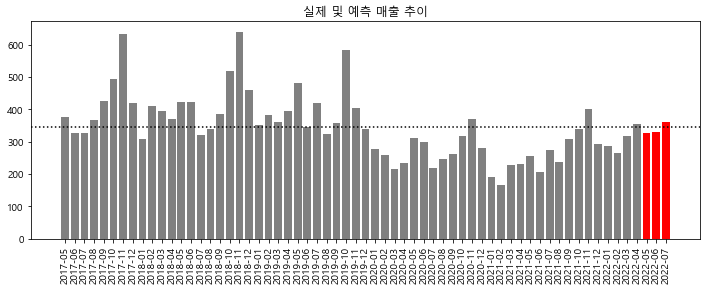

In [105]:
plt.figure(figsize=(12,4))
colors1 = np.append(np.repeat('grey',60), np.repeat('red',3))
sales_n_fcst = np.append(df2predict.head(60).saleSeries, [pred_nxmn, pred_nxmn2, pred_nxmn3])
df2predict.saleSeries = sales_n_fcst
plt.bar(df2predict.yrmon, df2predict.saleSeries,
        color=colors1)
plt.xticks(rotation=90)
plt.title('실제 및 예측 매출 추이')
plt.axhline(df2predict.saleSeries.head(60).mean(), color='black', linestyle=':')
plt.show()

In [106]:
dfpred2pivot = df2predict[['yrmon','monSeq', 'saleSeries']]
dfpred2pivot['year'] = dfpred2pivot.yrmon.str.slice(0,4)

dfpred_pivot = dfpred2pivot.pivot(index='monSeq', columns='year', values='saleSeries').reset_index()
dfpred_pivot.columns = dfpred_pivot.columns.astype(str)
dfpred_pivot

year,monSeq,2017,2018,2019,2020,2021,2022
0,0,NaN,308.473042,350.319064,277.982143,189.117997,287.799083
1,1,NaN,408.552779,380.868014,258.885423,167.206293,264.757336
2,2,NaN,394.025671,360.896774,215.699994,228.477869,318.194482
3,3,NaN,370.501526,393.508737,234.541214,230.711786,355.863483
4,4,374.919302,421.637087,481.468607,311.688203,255.570187,327.050806
5,5,326.366627,422.356873,345.575889,299.131015,205.168958,329.947259
6,6,327.838394,321.960482,418.126437,217.617506,273.177019,359.854973
7,7,367.511683,337.640522,322.349616,247.181771,235.989880,NaN
8,8,426.016588,385.014540,358.637067,260.783860,306.813636,NaN
9,9,492.615144,518.724478,583.772278,315.866747,340.052266,NaN


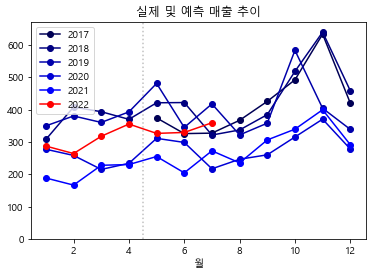

In [107]:
colorKeys = np.arange(2,8)/6
i=0
for x in dfpred_pivot.columns[1:]: 
    # 최근 년도일수록 밝은 색으로 구별
    colors1 = [0,0,colorKeys[i]]
    if i==5:
        # 최근 년도만 red로 강조
        colors1 = 'red'
    plt.plot(dfpred_pivot.monSeq+1, dfpred_pivot[x],
             marker='o',
             color=colors1)
    i+=1
plt.legend(dfpred_pivot.columns[1:])
plt.xlabel('월')
plt.title('실제 및 예측 매출 추이')
plt.axvline(4.5, linestyle=':', alpha=0.5, color='grey')

# 각 컬럼별 최대값 중에 최대값을 구해 범위 설정
plt.ylim(0,dfpred_pivot[dfpred_pivot.columns[1:]].max().max()*1.05)
plt.show()

## Section 5 : 외부환경요인의 매출영향도 분석

In [108]:
sales05.tail(3)

,mon,corona,musinsa,uniqlo,kakaoStyle,saleSeries,saleNxyr,saleNxmn,saleNxmn2,saleNxmn3,seq,monSeq,yrSeq,meanMonAmt,coronaCummean,predSales,yrmon
57,02,23.00,55.25,14.0,37.75,264.757336,0.0,318.194482,355.863483,0.0,57,1,4,0.604314,10.158621,201.310917,2022-02
58,03,25.75,53.00,15.0,54.50,318.194482,0.0,355.863483,0.000000,0.0,58,2,5,0.619429,10.422881,175.069394,2022-03
59,04,16.00,58.50,20.0,54.50,355.863483,0.0,0.000000,0.000000,0.0,59,3,5,0.647122,10.515833,174.371121,2022-04


#### 매출을 설명하는 모델 생성

In [109]:
from sklearn.linear_model import LinearRegression

# 판매금액계절지수 추가 변수를 포함해서  당월 매출을 추정하는 모델 생성
# 코로나 자체의 강도를 나타내는 외부 데이터 추가 필요
# 단, 계절적 판매지수 meanMonAmt 에는 코로나에 의한 영향이 반영되어 있어
# 얼마간 왜곡 존재 


feats = ['monSeq','yrSeq', 'meanMonAmt', 'corona','coronaCummean']
X = sales05[feats]
y = sales05.saleSeries
reg = LinearRegression().fit(X, y)

reg.score(X, y) # 결정계수 R2

0.7284320458877345

In [110]:
sales05[feats + ['saleSeries']].corr()

,monSeq,yrSeq,meanMonAmt,corona,coronaCummean,saleSeries
monSeq,1.000000,-0.099037,0.697101,-0.153921,-0.057940,0.431630
yrSeq,-0.099037,1.000000,-0.065723,0.581836,0.897425,-0.558853
meanMonAmt,0.697101,-0.065723,1.000000,-0.151015,-0.036756,0.619179
corona,-0.153921,0.581836,-0.151015,1.000000,0.580448,-0.550115
coronaCummean,-0.057940,0.897425,-0.036756,0.580448,1.000000,-0.584914
saleSeries,0.431630,-0.558853,0.619179,-0.550115,-0.584914,1.000000


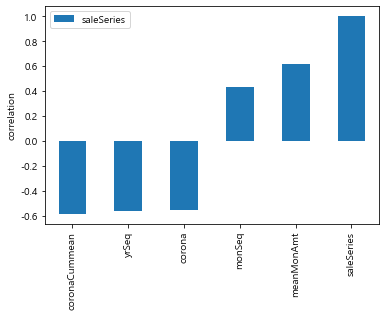

In [111]:
sales05[feats + ['saleSeries']].corr()[['saleSeries']].sort_values('saleSeries').plot(kind='bar')
plt.ylabel('correlation')
plt.show()

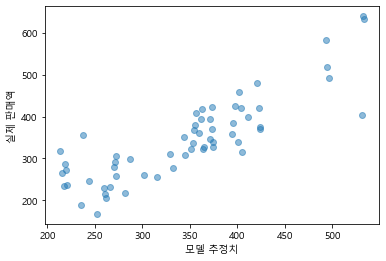

0.8534823055504632

In [112]:
# 과거기간의 실제 판매와 모델이 추정한 값 간의 관계
plt.scatter(reg.predict(X), y, alpha=0.5)
plt.xlabel('모델 추정치')
plt.ylabel('실제 판매액')
plt.show()

np.corrcoef(reg.predict(X), y)[0,1]

,mon,corona,musinsa,uniqlo,kakaoStyle,saleSeries,saleNxyr,saleNxmn,saleNxmn2,saleNxmn3,seq,monSeq,yrSeq,meanMonAmt,coronaCummean,predSales,yrmon
55,12,0,48.75,20.0,30.75,292.112797,0.0,287.799083,264.757336,318.194482,55,11,4,0.730866,0,298.951328,2021-12
56,01,0,45.80,17.2,36.40,287.799083,0.0,264.757336,318.194482,355.863483,56,0,4,0.577134,0,237.302906,2022-01
57,02,0,55.25,14.0,37.75,264.757336,0.0,318.194482,355.863483,0.000000,57,1,4,0.604314,0,201.310917,2022-02
58,03,0,53.00,15.0,54.50,318.194482,0.0,355.863483,0.000000,0.000000,58,2,5,0.619429,0,175.069394,2022-03
59,04,0,58.50,20.0,54.50,355.863483,0.0,0.000000,0.000000,0.000000,59,3,5,0.647122,0,174.371121,2022-04


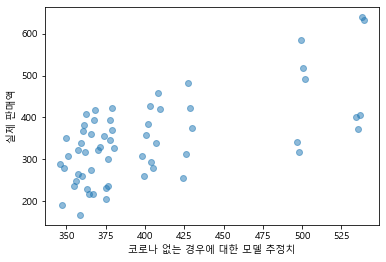

In [113]:
# 코로나가 전혀 없었을 경우의 값을 추정

sales05base = sales05.copy()
# 코로나 지수값을 0으로 변경
sales05base['corona'] = 0
# 코로가 없다고 가정하면 누적 값도 0
sales05base['coronaCummean'] = 0
X1 = sales05base[feats]
display( sales05base.tail())

# 과거기간의 실제 판매와 모델이 추정한 값 간의 관계
plt.scatter(reg.predict(X1), y, alpha=0.5)
plt.xlabel('코로나 없는 경우에 대한 모델 추정치')
plt.ylabel('실제 판매액')
plt.show()

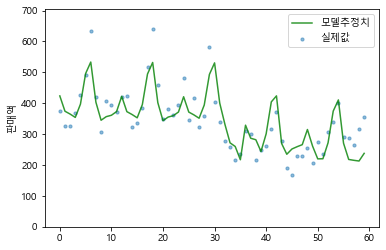

In [114]:
plt.plot(np.arange(len(X)), reg.predict(X), alpha=0.8, color='green')
plt.scatter(np.arange(len(X)), y, s=10, alpha=0.5)
plt.ylabel('판매액')
plt.legend(['모델추정치', '실제값'])
plt.ylim(0, max(y)*1.1)
plt.show()

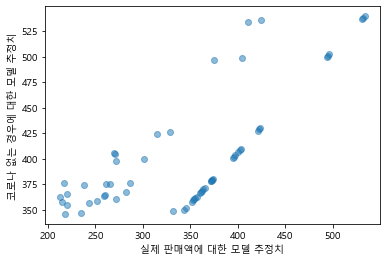

In [115]:
# 과거기간의 실제 판매와 모델이 추정한 값 간의 관계
plt.scatter(reg.predict(X), reg.predict(X1), alpha=0.5)
plt.xlabel('실제 판매액에 대한 모델 추정치')
plt.ylabel('코로나 없는 경우에 대한 모델 추정치')
plt.show()

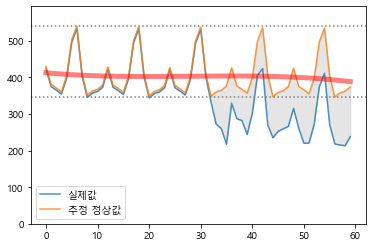

In [116]:
# 추정한 정상수준(baseline)과 실제값 간의 차이 영역에 색칠

fig, ax = plt.subplots()
ax.fill_between(np.arange(len(X1)), reg.predict(X), reg.predict(X1), 
                alpha=0.2, color='grey')
plt.plot(reg.predict(X), alpha=0.8)
plt.plot(reg.predict(X1), alpha=0.8)
plt.legend(['실제값', '추정 정상값'])
plt.axhline(reg.predict(X1).max(), color='grey', linestyle=':')
plt.axhline(reg.predict(X1).min(), color='grey', linestyle=':')
plt.ylim(0,reg.predict(X1).max()*1.1)

# 코로나가 없었을 경우에 대한 추정치의 추세 보조선
varx = np.arange(len(X1))
vary = reg.predict(X1)
plt.plot(np.unique(varx), np.poly1d(np.polyfit(varx, vary, 3))(np.unique(varx)), 
         color='red', linewidth=5, alpha=0.5)

plt.show()

In [117]:
dfimpact = sales05base[['yrmon', 'saleSeries']]
dfimpact['predAmt'] = reg.predict(X)
dfimpact['predAmt_noCorona'] = reg.predict(X1)
dfimpact['impactAmt'] = dfimpact.predAmt - dfimpact.predAmt_noCorona
dfimpact.tail()

,yrmon,saleSeries,predAmt,predAmt_noCorona,impactAmt
55,2021-12,292.112797,270.585133,403.997730,-133.412597
56,2022-01,287.799083,218.079962,345.743084,-127.663122
57,2022-02,264.757336,215.267673,357.357613,-142.089940
58,2022-03,318.194482,212.998011,361.859234,-148.861223
59,2022-04,355.863483,237.792000,373.718626,-135.926626


In [118]:
dfimpact1 = dfimpact[dfimpact.impactAmt< -10]
dfimpact1.tail()

,yrmon,saleSeries,predAmt,predAmt_noCorona,impactAmt
55,2021-12,292.112797,270.585133,403.997730,-133.412597
56,2022-01,287.799083,218.079962,345.743084,-127.663122
57,2022-02,264.757336,215.267673,357.357613,-142.089940
58,2022-03,318.194482,212.998011,361.859234,-148.861223
59,2022-04,355.863483,237.792000,373.718626,-135.926626


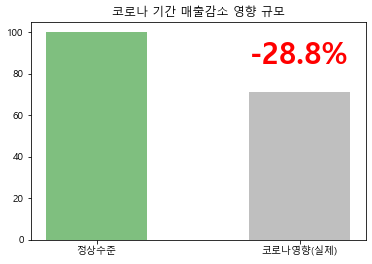

In [119]:
impactValue = dfimpact1.impactAmt.sum() / dfimpact1.predAmt_noCorona.sum() * 100

plt.bar(['정상수준', '코로나영향(실제)'], [100, 100+impactValue],
       color=['green', 'grey'], alpha=0.5, width=0.5)
plt.title('코로나 기간 매출감소 영향 규모')

# 소수점 한자리, 문자열 형식으로 변경, 뒤에 '%' 표시 붙임
text2show = str(round(impactValue,1)) + '%'
plt.text(1, 85, text2show, 
         # 좌표에 가운데 정렬
         ha='center', 
         size=30, color='red', 
         # 텍스트를 bold로 두껍게 표시
         weight='bold')
plt.show()

# 추정 정상수준 대비 28% 가량의 판매가 코로나로 인해 사라졌음을 확인